# Models

In this notebook we import the cleaned dataset that was created in the notebook Data Cleaning and Exploration, which is then used to train a variety of models, with the aim of finding the best model/dataset combination through means of different averaging windows on the dataset, and different network architectures for the neural networks

Import libraries

In [319]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint
import math
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import kerastuner
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import time
import xgboost as xgb

Import the cleaned dataset

In [731]:
df = pd.read_csv('./data/Cleaned Data/cleanedData.csv')

Take a quick look at the head of the dataset. We can see we again need to replace the index with the timestamp, and convert it to a datetime object

In [732]:
df.head()

,Timestamp,Air Temp,PAR,NOx Conc. 33m,GPP,CO2 Concentration,Rel. Humidity
0,2003-01-01 00:00:00,-23.21850,0.11767,1.275,0.0,381.525,99.41383
1,2003-01-01 01:00:00,-23.33533,0.11767,1.176,0.0,381.407,99.40667
2,2003-01-01 02:00:00,-23.45733,0.04983,1.222,0.0,381.371,100.56050
3,2003-01-01 03:00:00,-23.63433,0.05017,1.042,0.0,381.285,100.19917
4,2003-01-01 04:00:00,-23.62583,0.14525,0.967,0.0,381.292,98.42567


Convert the timestamp column to a datetime object

In [733]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

Set the timestamp as the index of the dataframe

In [734]:
df.set_index('Timestamp', inplace=True)

Take another look at the dataframe to verify it is as we expect

In [735]:
df.head()

,Air Temp,PAR,NOx Conc. 33m,GPP,CO2 Concentration,Rel. Humidity
Timestamp,,,,,,
2003-01-01 00:00:00,-23.21850,0.11767,1.275,0.0,381.525,99.41383
2003-01-01 01:00:00,-23.33533,0.11767,1.176,0.0,381.407,99.40667
2003-01-01 02:00:00,-23.45733,0.04983,1.222,0.0,381.371,100.56050
2003-01-01 03:00:00,-23.63433,0.05017,1.042,0.0,381.285,100.19917
2003-01-01 04:00:00,-23.62583,0.14525,0.967,0.0,381.292,98.42567


Calling info also verfies the index is a 'DatetimeIndex' and that we have the same number of non-null valies across the dataset

In [736]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 166740 entries, 2003-01-01 00:00:00 to 2022-12-31 23:00:00
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Air Temp           166740 non-null  float64
 1   PAR                166740 non-null  float64
 2   NOx Conc. 33m      166740 non-null  float64
 3   GPP                166740 non-null  float64
 4   CO2 Concentration  166740 non-null  float64
 5   Rel. Humidity      166740 non-null  float64
dtypes: float64(6)
memory usage: 8.9 MB


Here we are just moving the GPP column to the end to make it a bit easier to work with when we are splitting the target variables

In [737]:
df = df[['Air Temp', 'PAR', 'NOx Conc. 33m', 'CO2 Concentration', 'Rel. Humidity', 'GPP']]

In [738]:
df.head()

,Air Temp,PAR,NOx Conc. 33m,CO2 Concentration,Rel. Humidity,GPP
Timestamp,,,,,,
2003-01-01 00:00:00,-23.21850,0.11767,1.275,381.525,99.41383,0.0
2003-01-01 01:00:00,-23.33533,0.11767,1.176,381.407,99.40667,0.0
2003-01-01 02:00:00,-23.45733,0.04983,1.222,381.371,100.56050,0.0
2003-01-01 03:00:00,-23.63433,0.05017,1.042,381.285,100.19917,0.0
2003-01-01 04:00:00,-23.62583,0.14525,0.967,381.292,98.42567,0.0


## Regular dataset

Before passing the data to the model, it a good idea to standardize. This rescales each feature such that the mean = 0 and standard deviation = 1. This speeds up training, helps avoid convergence on a local minima, and avoids features that have a larger magnitude dominating those with a smaller magnitude. Scikit learns StandardScaler is used for this. Here we define the scaler and fit it to the data, saving the result in df_stand

In [1679]:
scaler = StandardScaler()
df_stand = scaler.fit_transform(df)

Here we define the proportion of data we want to use for training, with the remaining to be left for testing the model. Here we define it as 0.75, so 75% of the data will be used to train each model, with the remaining 25% left to test. This equates to 15 years training data, 5 years for testing

In [1680]:
perc_split = 0.75

In [1681]:
df_stand

array([[-2.93311188, -0.58434965,  0.05048673, -1.01626064,  0.93777339,
        -0.57796621],
       [-2.94546145, -0.58434965, -0.01533621, -1.02337962,  0.93741482,
        -0.57796621],
       [-2.95835752, -0.58454848,  0.01524819, -1.02555152,  0.99519762,
        -0.57796621],
       ...,
       [-0.15658066, -0.58492405, -0.46678853,  1.67892146,  0.56836917,
        -0.738406  ],
       [-0.17483283, -0.58492399, -0.53327635,  1.6657604 ,  0.62416334,
        -0.81683485],
       [-0.22893607, -0.58492314, -0.51997879,  1.64896142,  0.73591442,
        -0.66007141]])

Define the training and testing sets for the predictor variables. This is done by slicing the first 5 columns which relate to Air Temp, PAR, NOx Concentration, CO2 Concentrarion, and Relative Humidity. This is then split further such that the first 75% gets assigned to the train set, and the last 25% to the test set, using the perc_split variable we defined earlier

In [1682]:
x_train = df_stand[:, 0:5][:math.floor(len(df_stand)*perc_split)]
x_test = df_stand[:, 0:5][math.floor(len(df_stand)*perc_split):]

Verify the shape of the training and testing sets. We have 125055 samples in our train set, with 5 features in each, with 41685 samples in the test set

In [1683]:
x_train.shape, x_test.shape

((125055, 5), (41685, 5))

Split the target feature (GPP) into training and testing sets, similar to how we did above with the predictor variables

In [1684]:
y_train = df_stand[:, 5][:math.floor(len(df)*perc_split)]
y_test = df_stand[:, 5][math.floor(len(df)*perc_split):]

Verify the shape of the training and testing sets again. Here the second entries in the tuples are empty because this is a 1-dimensional numpy array. One thing we need to check is the length of the training and testing sets are identical between the x and y sets, which they are.

In [1685]:
y_train.shape, y_test.shape

((125055,), (41685,))

Define a sequential neural network. Here we have 6 layers, not including the input layer who's shape matches the shape of the feature array that will be passed ((5,) here as each predictor feature is a 1D array with 5 features). The number of neurons per layer decreases with each successive layer, starting at 64 neurons on the first hidden layer, down to 1 on the output layer.

We use rectified linear (relu) activations for all layers except the output layer, where we use a regular linear activation function. This is because GPP in the original dataset can be negative, and relu layers cannot predict negative values, while linear layers can. We also only use 1 neuron on the last layer because we want a single value for the prediction. 

For the loss function, which is used to inform the optimizer, MeanSquaredError (MSE) is used. This is a way for the model to measure its perfomance during training, and uses back propogation to improve the weights and biases based on a gradient descent algorithm. This is the role of the optimizer. Here we use adaptive momentum (adam), due to its use of momentum in the gradient descent algorithm, which further aids the avoidance of getting 'stuck' in a local minima. 

In [706]:
model1 = Sequential()
model1.add(Dense(64, input_shape=(5,), activation='relu'))
model1.add(Dense(32, activation='relu'))
model1.add(Dense(16, activation='relu'))
model1.add(Dense(8, activation='relu'))
model1.add(Dense(4, activation='relu'))
model1.add(Dense(1, activation='linear'))

model1.compile(loss='MeanSquaredError', optimizer=Adam(learning_rate=0.0001), metrics=['RootMeanSquaredError'])

Train the neural network for 100 epochs with 128 samples per batch. The full training history including MSE and RMSE on both the training and testing set it stored in the history variable

In [707]:
history = model1.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=128)

Epoch 1/100
977/977 [==============================] - 1s 739us/step - loss: 0.2211 - root_mean_squared_error: 0.4702 - val_loss: 0.1123 - val_root_mean_squared_error: 0.3351
Epoch 2/100
977/977 [==============================] - 1s 673us/step - loss: 0.0836 - root_mean_squared_error: 0.2891 - val_loss: 0.0987 - val_root_mean_squared_error: 0.3142
Epoch 3/100
977/977 [==============================] - 1s 671us/step - loss: 0.0783 - root_mean_squared_error: 0.2798 - val_loss: 0.0928 - val_root_mean_squared_error: 0.3047
Epoch 4/100
977/977 [==============================] - 1s 669us/step - loss: 0.0755 - root_mean_squared_error: 0.2748 - val_loss: 0.0915 - val_root_mean_squared_error: 0.3026
Epoch 5/100
977/977 [==============================] - 1s 667us/step - loss: 0.0738 - root_mean_squared_error: 0.2716 - val_loss: 0.0887 - val_root_mean_squared_error: 0.2979
Epoch 6/100
977/977 [==============================] - 1s 669us/step - loss: 0.0728 - root_mean_squared_error: 0.2698 - val_l

977/977 [==============================] - 1s 663us/step - loss: 0.0666 - root_mean_squared_error: 0.2581 - val_loss: 0.0840 - val_root_mean_squared_error: 0.2898
Epoch 48/100
977/977 [==============================] - 1s 667us/step - loss: 0.0666 - root_mean_squared_error: 0.2581 - val_loss: 0.0830 - val_root_mean_squared_error: 0.2881
Epoch 49/100
977/977 [==============================] - 1s 668us/step - loss: 0.0666 - root_mean_squared_error: 0.2581 - val_loss: 0.0856 - val_root_mean_squared_error: 0.2925
Epoch 50/100
977/977 [==============================] - 1s 665us/step - loss: 0.0666 - root_mean_squared_error: 0.2580 - val_loss: 0.0828 - val_root_mean_squared_error: 0.2877
Epoch 51/100
977/977 [==============================] - 1s 666us/step - loss: 0.0665 - root_mean_squared_error: 0.2578 - val_loss: 0.0833 - val_root_mean_squared_error: 0.2887
Epoch 52/100
977/977 [==============================] - 1s 666us/step - loss: 0.0665 - root_mean_squared_error: 0.2579 - val_loss: 0.

977/977 [==============================] - 1s 693us/step - loss: 0.0654 - root_mean_squared_error: 0.2558 - val_loss: 0.0853 - val_root_mean_squared_error: 0.2921
Epoch 94/100
977/977 [==============================] - 1s 676us/step - loss: 0.0653 - root_mean_squared_error: 0.2556 - val_loss: 0.0827 - val_root_mean_squared_error: 0.2875
Epoch 95/100
977/977 [==============================] - 1s 673us/step - loss: 0.0653 - root_mean_squared_error: 0.2555 - val_loss: 0.0840 - val_root_mean_squared_error: 0.2898
Epoch 96/100
977/977 [==============================] - 1s 677us/step - loss: 0.0652 - root_mean_squared_error: 0.2554 - val_loss: 0.0866 - val_root_mean_squared_error: 0.2942
Epoch 97/100
977/977 [==============================] - 1s 677us/step - loss: 0.0652 - root_mean_squared_error: 0.2553 - val_loss: 0.0833 - val_root_mean_squared_error: 0.2886
Epoch 98/100
977/977 [==============================] - 1s 688us/step - loss: 0.0653 - root_mean_squared_error: 0.2554 - val_loss: 0.

View what is stored in the history variable. Each of these contains the information for the entire 100 epochs

In [710]:
history.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

We can then plot the RMSE on the validation set for the entire training process. We can see the RMSE rapidly decreases until around the 20th epoch before levelling off

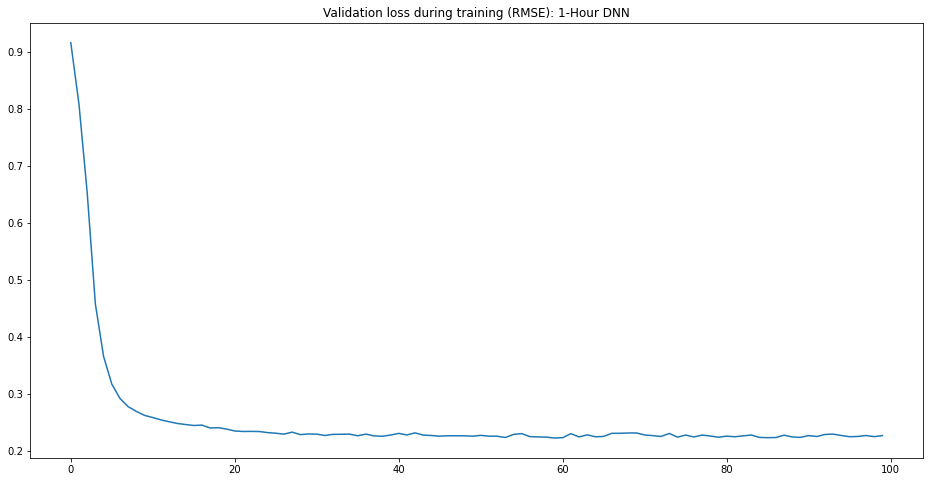

In [1686]:
plt.figure(figsize=(16,8))
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Validation loss during training (RMSE): 1-Hour DNN')
plt.show()

We can also get the index of the minumum validation RMSE, which occured on the 77th epoch

In [1687]:
np.argmin(history.history['val_root_mean_squared_error'])

59

Create predictions from the model by passing in the testing set, storing the results in the y_pred variable

In [1688]:
y_pred = model1.predict(x_test)

We can then plot the testing set (true, observed values for GPP) on the top, with the prediced values from the network on the bottom. We can see the network was correctly able to encode the seasonal trends, albeit it underpredicting during the peak of summer

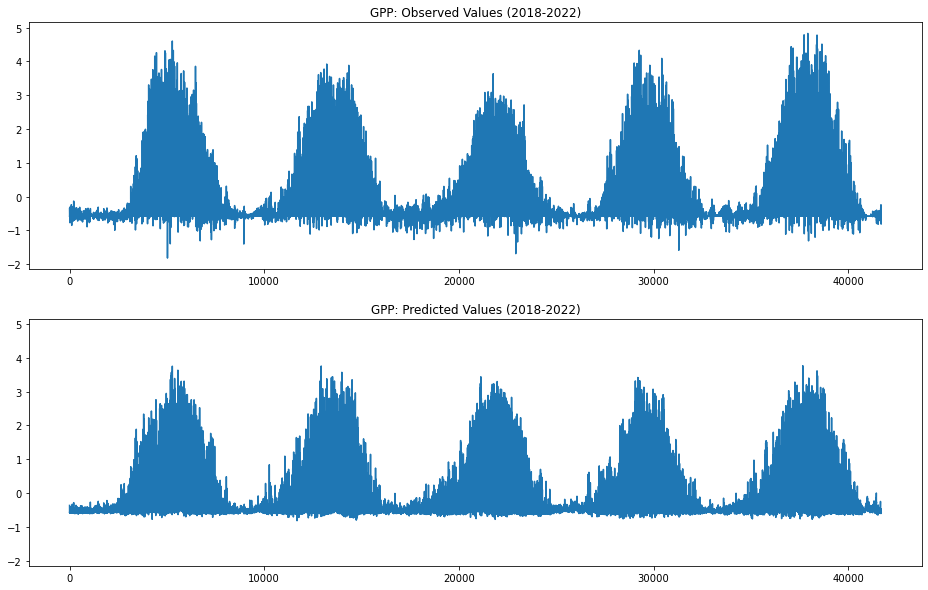

In [1689]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16,10), sharey=True)

ax[0].plot(y_test)
ax[0].set_title('GPP: Observed Values (2018-2022)')

ax[1].plot(y_pred)
ax[1].set_title('GPP: Predicted Values (2018-2022)')

plt.show()

Here we calculate the residuals, which is the difference between observed and predicted values

In [725]:
residuals = y_test - y_pred.flatten()
res_r = list(range(len(residuals)))

We can then plot these residuals, which verfies our observation that the model has a tendency to underpredict in the summer, except for the third year where lower than usual GPP values were observed

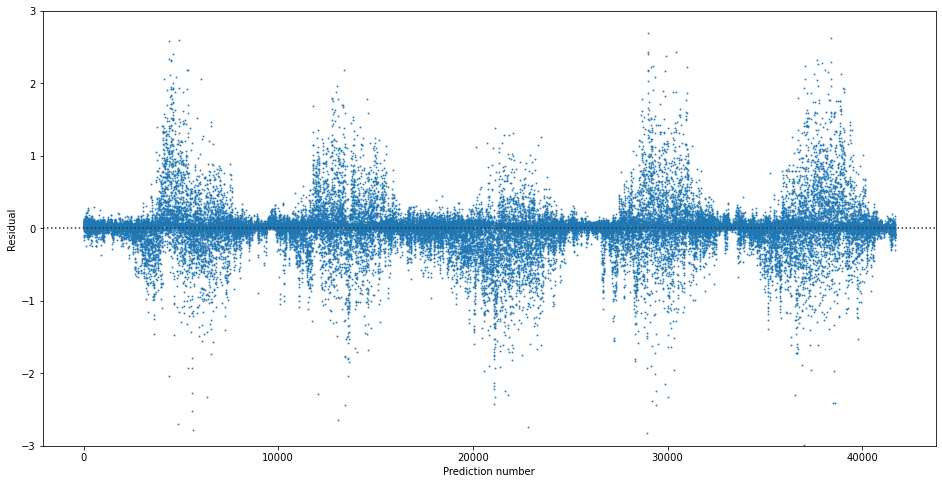

In [782]:
fig = plt.figure(figsize=(16,8))
sns.residplot(x=res_r, y=residuals, scatter_kws=dict(s=1))
plt.xlabel('Prediction number')
plt.ylabel('Residual')
plt.ylim(-3, 3)
plt.show()

We can also plot a histogram of the residuals, which shows the distribution of the residuals across all of the predictions

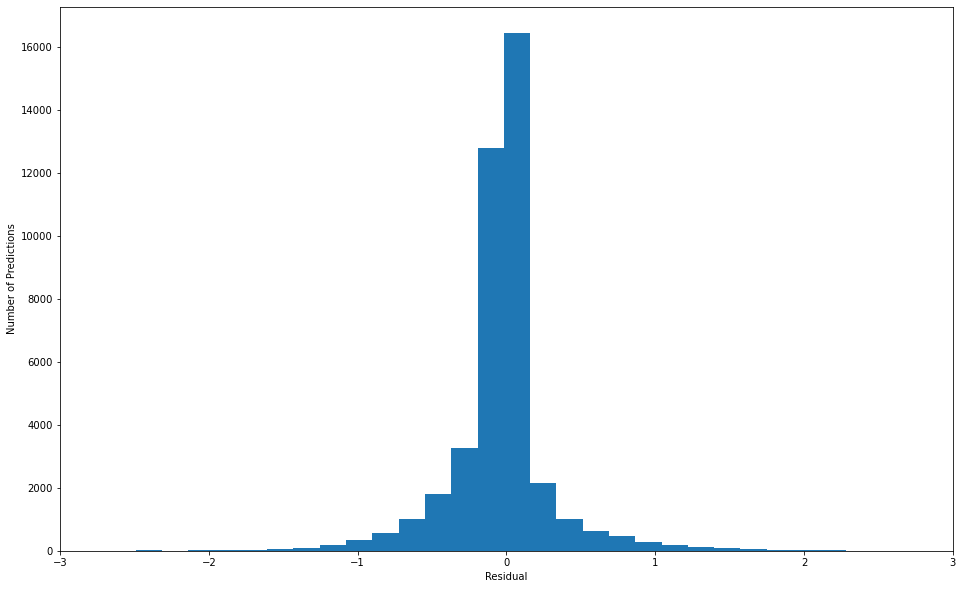

In [781]:
fig = plt.figure(figsize=(16,10))
plt.hist(residuals, bins=40)
plt.ylabel('Number of Predictions')
plt.xlabel('Residual')
plt.xlim(-3,3)
plt.show()

##### Going forwards, as we have already walked through the process of training and testing a model, much of these comments will not be repeated. Only new methods that have been added will be commented

## LSTM dataset

Below we are training a Long Short-Term memory (LSTM) network which takes in a series of samples leading up to the prediction, which means we need to restructure the data. Below we define a function which takes in a dataframe and converts it to a format that can be used by the LSTM. By default, we use a window size of 5, so samples from t - 5 to t - 1 are used in the prediction of time t. 

In [1690]:
def df_to_lstm(df, window_size=5):
    X = []
    y = []
    for i in range(len(df) - window_size):
        row = df[i : i + window_size, : 5]
        X.append(row)
        label = df[:,-1][i + window_size]
        y.append(label)
    return np.array(X), np.array(y)

Create the predictor and target sets, and then further split them into training and testing sets

In [1691]:
X, y = df_to_lstm(df_stand)

In [1692]:
X.shape, y.shape

((166735, 5, 5), (166735,))

In [1693]:
x_train = X[:math.floor(len(X)*perc_split)]
x_test = X[math.floor(len(X)*perc_split):]

x_train.shape, x_test.shape

((125051, 5, 5), (41684, 5, 5))

In [1694]:
y_train = y[:math.floor(len(y)*perc_split)]
y_test = y[math.floor(len(y)*perc_split):]

y_train.shape, y_test.shape

((125051,), (41684,))

Here we are training an indentical model as before, except the first hidden layer has been replaced by an LSTM layer with the same number of neurons in the dense layer. We use no activation function here to avoid clipping at the higher predictions for GPP

In [764]:
model2 = Sequential()
model2.add(InputLayer((5,5)))
model2.add(LSTM(64, activation=None))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(16, activation='relu'))
model2.add(Dense(8, activation='relu'))
model2.add(Dense(4, activation='relu'))
model2.add(Dense(1, activation='linear'))

model2.compile(loss='MeanSquaredError', optimizer=Adam(learning_rate=0.0001), metrics=['RootMeanSquaredError'])

In [765]:
history = model2.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=128)

Epoch 1/100
977/977 [==============================] - 3s 2ms/step - loss: 0.4365 - root_mean_squared_error: 0.6607 - val_loss: 0.2035 - val_root_mean_squared_error: 0.4511
Epoch 2/100
977/977 [==============================] - 2s 2ms/step - loss: 0.1539 - root_mean_squared_error: 0.3923 - val_loss: 0.1486 - val_root_mean_squared_error: 0.3855
Epoch 3/100
977/977 [==============================] - 2s 2ms/step - loss: 0.1375 - root_mean_squared_error: 0.3708 - val_loss: 0.1478 - val_root_mean_squared_error: 0.3844
Epoch 4/100
977/977 [==============================] - 2s 2ms/step - loss: 0.1313 - root_mean_squared_error: 0.3624 - val_loss: 0.1332 - val_root_mean_squared_error: 0.3649
Epoch 5/100
977/977 [==============================] - 2s 2ms/step - loss: 0.1281 - root_mean_squared_error: 0.3579 - val_loss: 0.1313 - val_root_mean_squared_error: 0.3624
Epoch 6/100
977/977 [==============================] - 2s 2ms/step - loss: 0.1260 - root_mean_squared_error: 0.3550 - val_loss: 0.1278 

977/977 [==============================] - 2s 2ms/step - loss: 0.1092 - root_mean_squared_error: 0.3305 - val_loss: 0.1179 - val_root_mean_squared_error: 0.3433
Epoch 49/100
977/977 [==============================] - 2s 2ms/step - loss: 0.1090 - root_mean_squared_error: 0.3301 - val_loss: 0.1202 - val_root_mean_squared_error: 0.3467
Epoch 50/100
977/977 [==============================] - 2s 2ms/step - loss: 0.1088 - root_mean_squared_error: 0.3299 - val_loss: 0.1242 - val_root_mean_squared_error: 0.3524
Epoch 51/100
977/977 [==============================] - 2s 2ms/step - loss: 0.1091 - root_mean_squared_error: 0.3303 - val_loss: 0.1197 - val_root_mean_squared_error: 0.3460
Epoch 52/100
977/977 [==============================] - 2s 2ms/step - loss: 0.1086 - root_mean_squared_error: 0.3296 - val_loss: 0.1183 - val_root_mean_squared_error: 0.3440
Epoch 53/100
977/977 [==============================] - 2s 2ms/step - loss: 0.1085 - root_mean_squared_error: 0.3294 - val_loss: 0.1190 - val_r

977/977 [==============================] - 2s 2ms/step - loss: 0.1052 - root_mean_squared_error: 0.3243 - val_loss: 0.1272 - val_root_mean_squared_error: 0.3566
Epoch 96/100
977/977 [==============================] - 2s 2ms/step - loss: 0.1049 - root_mean_squared_error: 0.3240 - val_loss: 0.1202 - val_root_mean_squared_error: 0.3467
Epoch 97/100
977/977 [==============================] - 2s 2ms/step - loss: 0.1050 - root_mean_squared_error: 0.3240 - val_loss: 0.1149 - val_root_mean_squared_error: 0.3389
Epoch 98/100
977/977 [==============================] - 2s 2ms/step - loss: 0.1047 - root_mean_squared_error: 0.3236 - val_loss: 0.1154 - val_root_mean_squared_error: 0.3397
Epoch 99/100
977/977 [==============================] - 2s 2ms/step - loss: 0.1046 - root_mean_squared_error: 0.3235 - val_loss: 0.1185 - val_root_mean_squared_error: 0.3442
Epoch 100/100
977/977 [==============================] - 2s 2ms/step - loss: 0.1050 - root_mean_squared_error: 0.3240 - val_loss: 0.1184 - val_

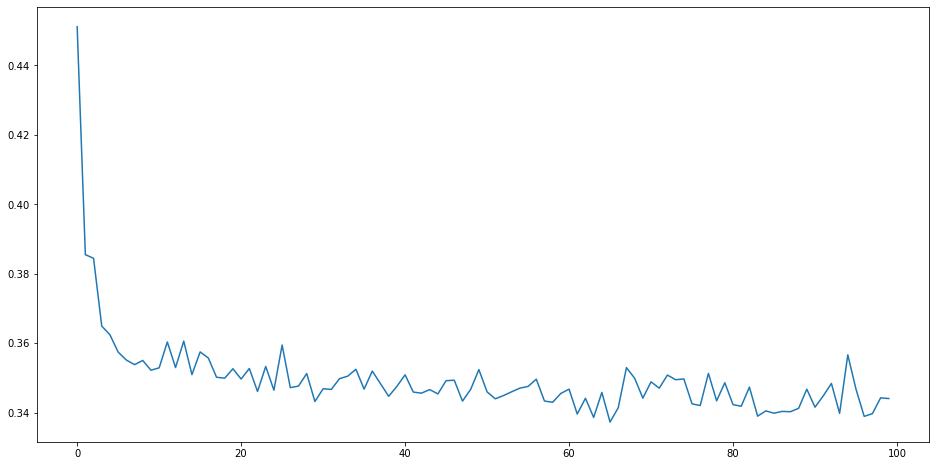

In [766]:
plt.figure(figsize=(16,8))
plt.plot(history.history['val_root_mean_squared_error'])
plt.show()

In [769]:
np.argmin(history.history['val_root_mean_squared_error'])

65

In [1695]:
y_pred = model2.predict(x_test)

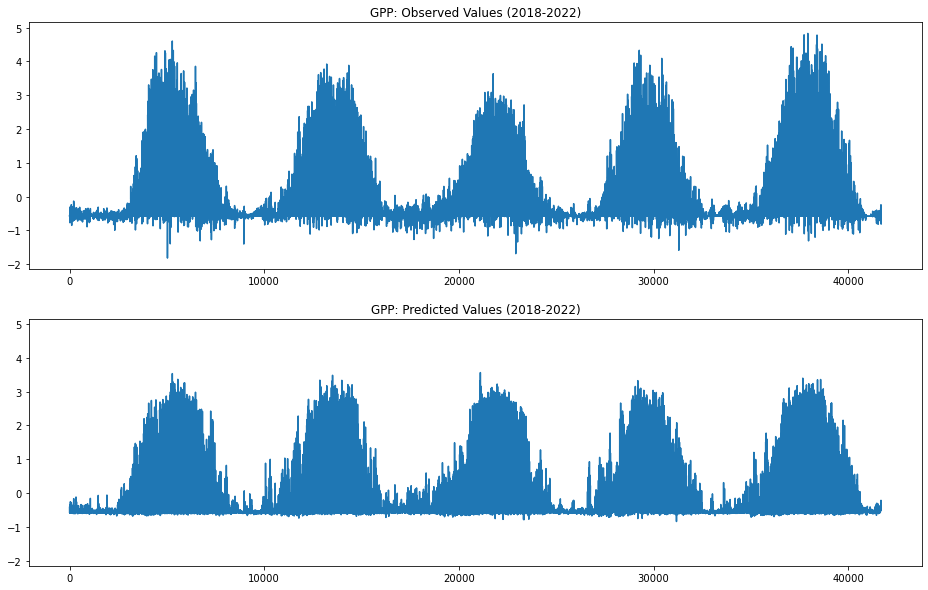

In [1696]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16,10), sharey=True)

ax[0].plot(y_test)
ax[0].set_title('GPP: Observed Values (2018-2022)')

ax[1].plot(y_pred)
ax[1].set_title('GPP: Predicted Values (2018-2022)')

plt.show()

In [777]:
residuals = y_test - y_pred.flatten()
res_r = list(range(len(residuals)))

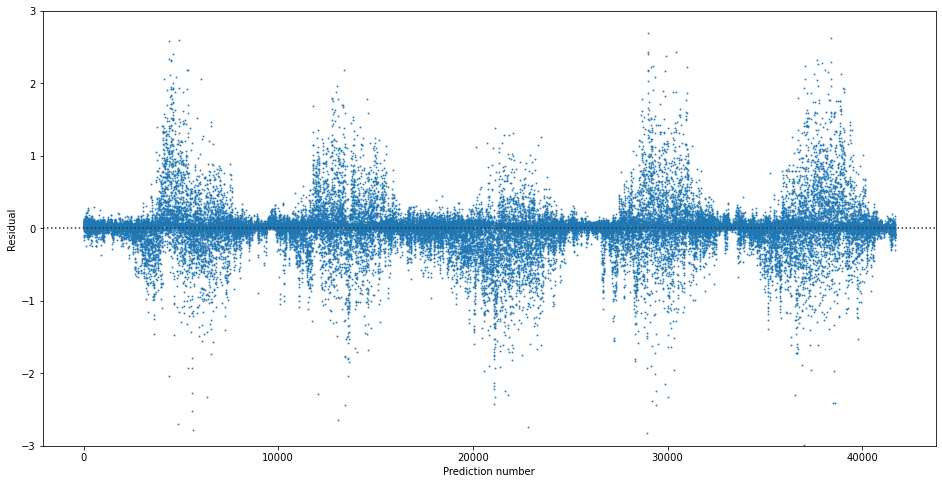

In [780]:
fig = plt.figure(figsize=(16,8))
sns.residplot(x=res_r, y=residuals, scatter_kws=dict(s=1))
plt.xlabel('Prediction number')
plt.ylabel('Residual')
plt.ylim(-3, 3)
plt.show()

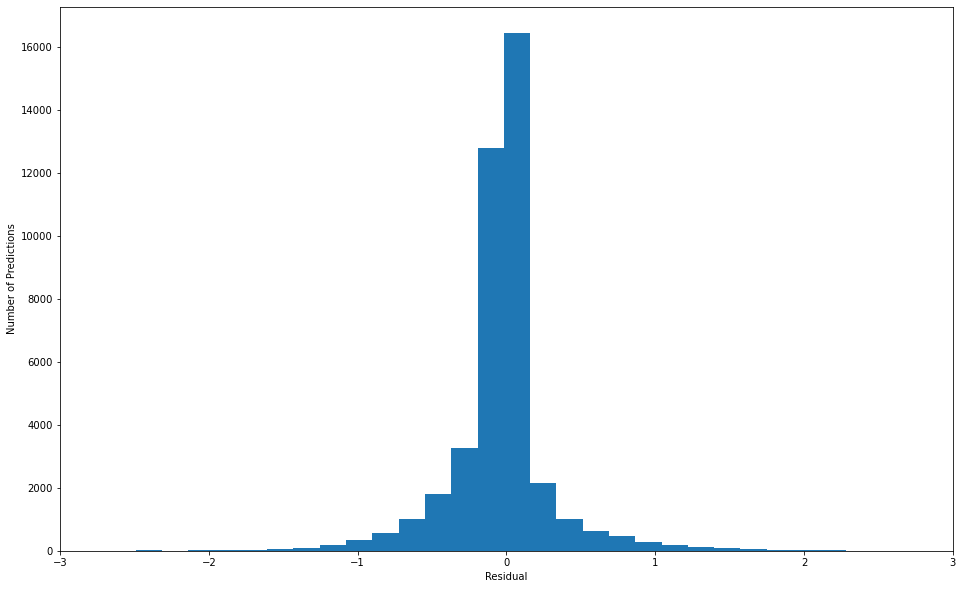

In [773]:
fig = plt.figure(figsize=(16,10))
plt.hist(residuals, bins=40)
plt.ylabel('Number of Predictions')
plt.xlabel('Residual')
plt.xlim(-3, 3)
plt.show()

## 6 hour averaging dataset

For this model, we resample the dataset to take the mean of all features in 6 hour windows. This should further reduce noise in the dataset and make the relationships between predictor and target features easier for the model to distinguish

In [1697]:
df_6h = df.resample('6H').mean()

In [1698]:
df_6h.head()

,Air Temp,PAR,NOx Conc. 33m,CO2 Concentration,Rel. Humidity,GPP
Timestamp,,,,,,
2003-01-01 00:00:00,-23.500915,0.099682,1.098333,381.377167,99.304640,0.0
2003-01-01 06:00:00,-22.564250,27.646777,0.634000,382.330500,97.263417,0.0
2003-01-01 12:00:00,-20.128248,40.694417,1.821833,382.230333,95.092602,0.0
2003-01-01 18:00:00,-21.141057,0.049945,1.581667,382.758167,95.271193,0.0
2003-01-02 00:00:00,-21.530888,-0.024222,1.330333,382.721500,95.479867,0.0


This has generated some NA values. This is from having timestamps that are missing from the previous notebook where we removed some samples. We can go ahead and drop these

In [1699]:
df_6h.isna().sum()

Air Temp             1147
PAR                  1147
NOx Conc. 33m        1147
CO2 Concentration    1147
Rel. Humidity        1147
GPP                  1147
dtype: int64

In [1700]:
df_6h = df_6h.dropna()

In [1701]:
df_stand = scaler.fit_transform(df_6h)

In [1702]:
x_train = df_stand[:, :-1][:math.floor(len(df_stand)*perc_split)]
x_test = df_stand[:, :-1][math.floor(len(df_stand)*perc_split):]

x_train.shape, x_test.shape

((21054, 5), (7019, 5))

In [1703]:
y_train = df_stand[:, -1][:math.floor(len(df_stand)*perc_split)]
y_test = df_stand[:, -1][math.floor(len(df_stand)*perc_split):]

y_train.shape, y_test.shape

((21054,), (7019,))

In [823]:
model3 = Sequential()
model3.add(Dense(64, input_shape=(5,), activation='relu'))
model3.add(Dense(32, activation='relu'))
model3.add(Dense(16, activation='relu'))
model3.add(Dense(8, activation='relu'))
model3.add(Dense(4, activation='relu'))
model3.add(Dense(1, activation='linear'))

model3.compile(loss='MeanSquaredError', optimizer=Adam(learning_rate=0.0001), metrics=['RootMeanSquaredError'])

In [824]:
history = model3.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=128)

Epoch 1/100
165/165 [==============================] - 0s 1ms/step - loss: 0.7724 - root_mean_squared_error: 0.8789 - val_loss: 0.4341 - val_root_mean_squared_error: 0.6589
Epoch 2/100
165/165 [==============================] - 0s 745us/step - loss: 0.2708 - root_mean_squared_error: 0.5203 - val_loss: 0.1805 - val_root_mean_squared_error: 0.4249
Epoch 3/100
165/165 [==============================] - 0s 723us/step - loss: 0.1330 - root_mean_squared_error: 0.3647 - val_loss: 0.1419 - val_root_mean_squared_error: 0.3766
Epoch 4/100
165/165 [==============================] - 0s 732us/step - loss: 0.0913 - root_mean_squared_error: 0.3021 - val_loss: 0.1218 - val_root_mean_squared_error: 0.3490
Epoch 5/100
165/165 [==============================] - 0s 732us/step - loss: 0.0787 - root_mean_squared_error: 0.2805 - val_loss: 0.1073 - val_root_mean_squared_error: 0.3276
Epoch 6/100
165/165 [==============================] - 0s 745us/step - loss: 0.0731 - root_mean_squared_error: 0.2703 - val_los

165/165 [==============================] - 0s 741us/step - loss: 0.0539 - root_mean_squared_error: 0.2321 - val_loss: 0.0694 - val_root_mean_squared_error: 0.2634
Epoch 48/100
165/165 [==============================] - 0s 757us/step - loss: 0.0538 - root_mean_squared_error: 0.2318 - val_loss: 0.0696 - val_root_mean_squared_error: 0.2637
Epoch 49/100
165/165 [==============================] - 0s 741us/step - loss: 0.0537 - root_mean_squared_error: 0.2318 - val_loss: 0.0665 - val_root_mean_squared_error: 0.2579
Epoch 50/100
165/165 [==============================] - 0s 732us/step - loss: 0.0536 - root_mean_squared_error: 0.2315 - val_loss: 0.0707 - val_root_mean_squared_error: 0.2659
Epoch 51/100
165/165 [==============================] - 0s 729us/step - loss: 0.0536 - root_mean_squared_error: 0.2314 - val_loss: 0.0682 - val_root_mean_squared_error: 0.2612
Epoch 52/100
165/165 [==============================] - 0s 723us/step - loss: 0.0534 - root_mean_squared_error: 0.2312 - val_loss: 0.

165/165 [==============================] - 0s 729us/step - loss: 0.0515 - root_mean_squared_error: 0.2268 - val_loss: 0.0694 - val_root_mean_squared_error: 0.2634
Epoch 94/100
165/165 [==============================] - 0s 723us/step - loss: 0.0516 - root_mean_squared_error: 0.2271 - val_loss: 0.0698 - val_root_mean_squared_error: 0.2643
Epoch 95/100
165/165 [==============================] - 0s 723us/step - loss: 0.0515 - root_mean_squared_error: 0.2268 - val_loss: 0.0698 - val_root_mean_squared_error: 0.2643
Epoch 96/100
165/165 [==============================] - 0s 726us/step - loss: 0.0515 - root_mean_squared_error: 0.2269 - val_loss: 0.0687 - val_root_mean_squared_error: 0.2621
Epoch 97/100
165/165 [==============================] - 0s 729us/step - loss: 0.0514 - root_mean_squared_error: 0.2267 - val_loss: 0.0726 - val_root_mean_squared_error: 0.2695
Epoch 98/100
165/165 [==============================] - 0s 723us/step - loss: 0.0514 - root_mean_squared_error: 0.2268 - val_loss: 0.

We can see that not only did the 6 hour averaged dataset lower the RMSE on the validation set, but the variance of RMSE across epochs was also vastly reduced, reinfocing our beliefs that the relationships between predictor and target are more stable and as such easier to learn

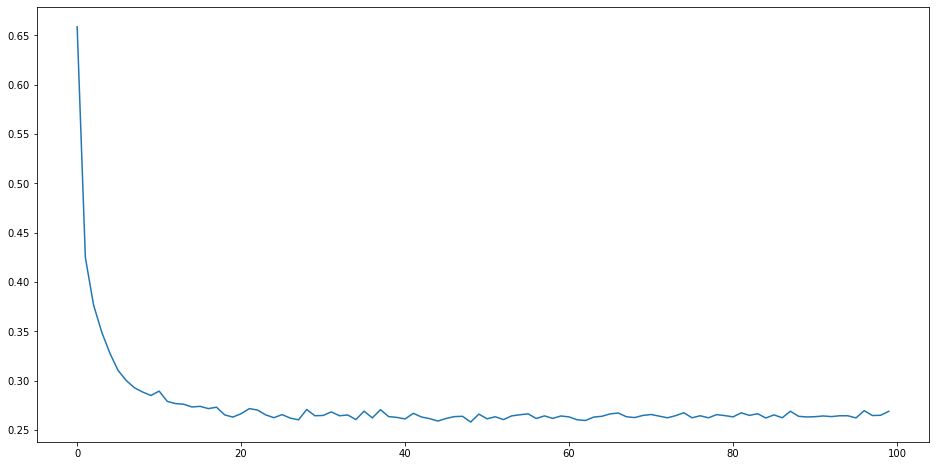

In [825]:
plt.figure(figsize=(16,8))
plt.plot(history.history['val_root_mean_squared_error'])
plt.show()

In [826]:
np.argmin(history.history['val_root_mean_squared_error'])

48

In [1704]:
y_pred = model3.predict(x_test)

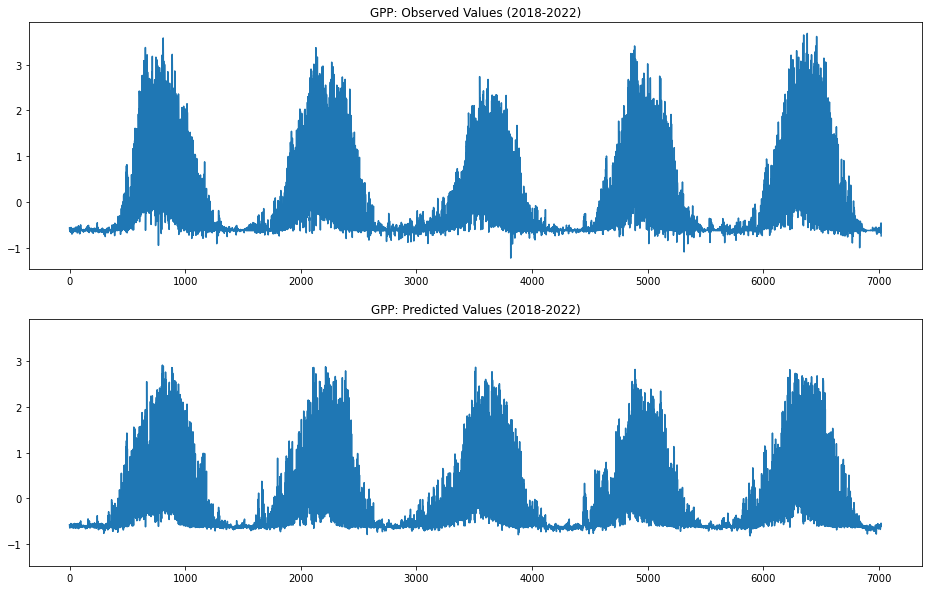

In [1705]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16,10), sharey=True)

ax[0].plot(y_test)
ax[0].set_title('GPP: Observed Values (2018-2022)')

ax[1].plot(y_pred)
ax[1].set_title('GPP: Predicted Values (2018-2022)')

plt.show()

In [829]:
residuals = y_test - y_pred.flatten()
res_r = list(range(len(residuals)))

The residual plot is also improved. Although part of it is because we have less total points plotted so it looks less noisy. The model still does keep a tendency to underpredict in the summer, except year 3 again

Text(0, 0.5, 'Residual')

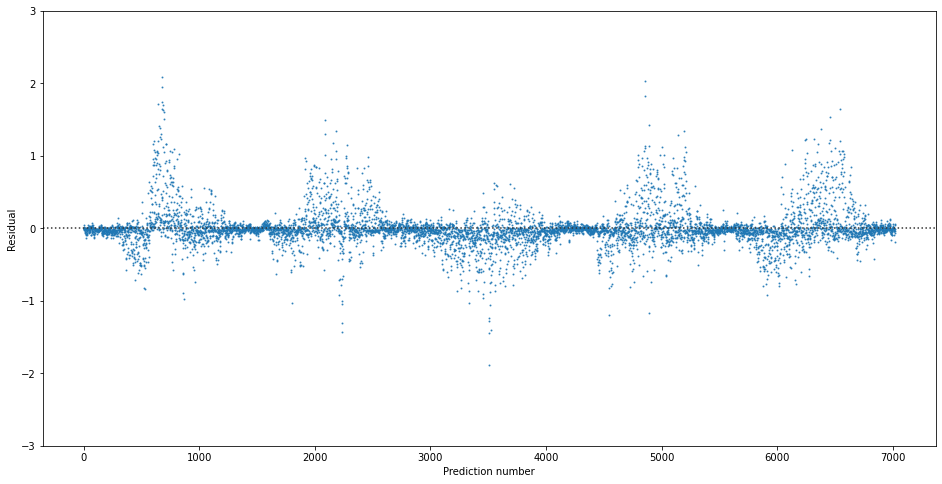

In [830]:
fig = plt.figure(figsize=(16,8))
sns.residplot(x=res_r, y=residuals, scatter_kws=dict(s=1))
plt.xlabel('Prediction number')
plt.ylim(-3,3)
plt.ylabel('Residual')

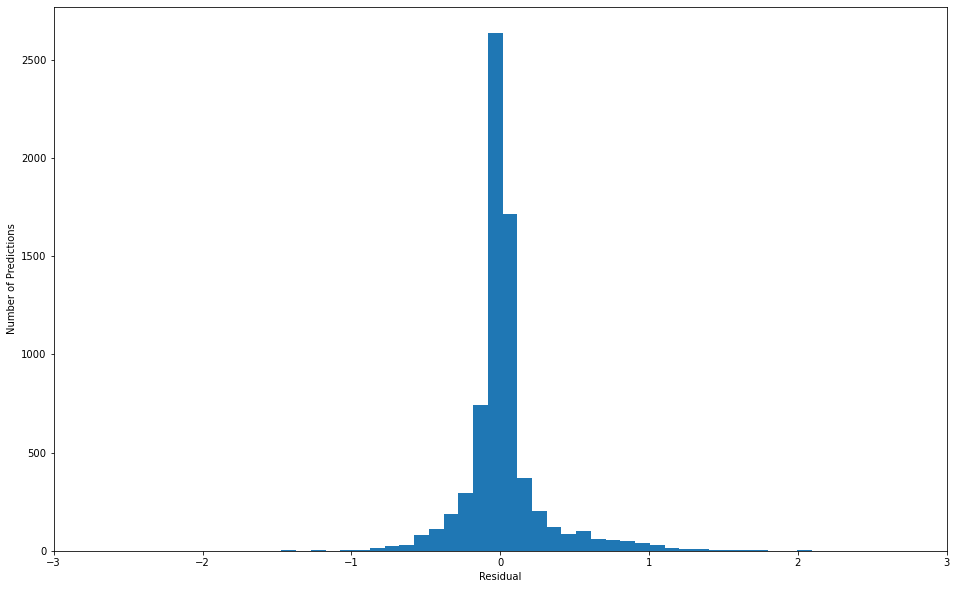

In [831]:
fig = plt.figure(figsize=(16,10))
plt.hist(residuals, bins=40)
plt.ylabel('Number of Predictions')
plt.xlabel('Residual')
plt.xlim(-3,3)
plt.show()

## 12 hour averaging dataset

Here we repeat the process for the 6 hour averaging, except using 12 hour averaging instead

In [1706]:
df_12h = df.resample('12H').mean()

In [1707]:
df_12h.head()

,Air Temp,PAR,NOx Conc. 33m,CO2 Concentration,Rel. Humidity,GPP
Timestamp,,,,,,
2003-01-01 00:00:00,-23.032583,13.873229,0.866167,381.853833,98.284028,0.000000
2003-01-01 12:00:00,-20.634652,20.372181,1.701750,382.494250,95.181897,0.000000
2003-01-02 00:00:00,-21.352692,13.422868,1.708667,383.484426,95.464748,0.102583
2003-01-02 12:00:00,-18.064528,20.531903,2.158667,381.349167,94.719952,0.148542
2003-01-03 00:00:00,-20.958792,11.028489,2.371667,382.634333,95.696625,0.133917


In [1708]:
df_12h.isna().sum()

Air Temp             504
PAR                  504
NOx Conc. 33m        504
CO2 Concentration    504
Rel. Humidity        504
GPP                  504
dtype: int64

In [1709]:
df_12h = df_12h.dropna()

In [1710]:
df_stand = scaler.fit_transform(df_12h)

In [1711]:
df_stand

array([[-2.93986191, -0.94251622, -0.24565028, -1.02145879,  0.9499306 ,
        -0.89093271],
       [-2.68418905, -0.90975057,  0.36696248, -0.98200895,  0.78251884,
        -0.89093271],
       [-2.76074805, -0.9447868 ,  0.37203348, -0.92101386,  0.79778337,
        -0.86131362],
       ...,
       [-0.36879511, -0.9803676 ,  0.00789943,  1.90837976,  1.00245428,
        -0.79897157],
       [-0.37308666, -1.00270073, -0.59780945,  1.68427493,  0.83432642,
        -0.86054367],
       [-0.21888102, -0.99077524, -0.42570112,  1.78553164,  0.79367421,
        -0.85709091]])

In [1712]:
x_train = df_stand[:, 0:5][:math.floor(len(df_stand)*perc_split)]
x_test = df_stand[:, 0:5][math.floor(len(df_stand)*perc_split):]

x_train.shape, x_test.shape

((10579, 5), (3527, 5))

In [1713]:
y_train = df_stand[:, 5][:math.floor(len(df_stand)*perc_split)]
y_test = df_stand[:, 5][math.floor(len(df_stand)*perc_split):]

y_train.shape, y_test.shape

((10579,), (3527,))

In [855]:
model4 = Sequential()
model4.add(Dense(64, input_shape=(5,), activation='relu'))
model4.add(Dense(32, activation='relu'))
model4.add(Dense(16, activation='relu'))
model4.add(Dense(8, activation='relu'))
model4.add(Dense(4, activation='relu'))
model4.add(Dense(1, activation='linear'))

model4.compile(loss='MeanSquaredError', optimizer=Adam(learning_rate=0.0001), metrics=['RootMeanSquaredError'])

In [856]:
history = model4.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=128)

Epoch 1/100
83/83 [==============================] - 0s 2ms/step - loss: 0.9524 - root_mean_squared_error: 0.9759 - val_loss: 0.8657 - val_root_mean_squared_error: 0.9304
Epoch 2/100
83/83 [==============================] - 0s 836us/step - loss: 0.8012 - root_mean_squared_error: 0.8951 - val_loss: 0.7183 - val_root_mean_squared_error: 0.8475
Epoch 3/100
83/83 [==============================] - 0s 812us/step - loss: 0.5875 - root_mean_squared_error: 0.7665 - val_loss: 0.5375 - val_root_mean_squared_error: 0.7331
Epoch 4/100
83/83 [==============================] - 0s 799us/step - loss: 0.4501 - root_mean_squared_error: 0.6709 - val_loss: 0.4580 - val_root_mean_squared_error: 0.6767
Epoch 5/100
83/83 [==============================] - 0s 787us/step - loss: 0.3948 - root_mean_squared_error: 0.6284 - val_loss: 0.4222 - val_root_mean_squared_error: 0.6498
Epoch 6/100
83/83 [==============================] - 0s 787us/step - loss: 0.3674 - root_mean_squared_error: 0.6062 - val_loss: 0.3955 - 

83/83 [==============================] - 0s 793us/step - loss: 0.0995 - root_mean_squared_error: 0.3155 - val_loss: 0.1236 - val_root_mean_squared_error: 0.3516
Epoch 49/100
83/83 [==============================] - 0s 812us/step - loss: 0.0973 - root_mean_squared_error: 0.3119 - val_loss: 0.1203 - val_root_mean_squared_error: 0.3468
Epoch 50/100
83/83 [==============================] - 0s 799us/step - loss: 0.0952 - root_mean_squared_error: 0.3085 - val_loss: 0.1194 - val_root_mean_squared_error: 0.3456
Epoch 51/100
83/83 [==============================] - 0s 799us/step - loss: 0.0935 - root_mean_squared_error: 0.3058 - val_loss: 0.1170 - val_root_mean_squared_error: 0.3421
Epoch 52/100
83/83 [==============================] - 0s 824us/step - loss: 0.0916 - root_mean_squared_error: 0.3026 - val_loss: 0.1156 - val_root_mean_squared_error: 0.3401
Epoch 53/100
83/83 [==============================] - 0s 812us/step - loss: 0.0900 - root_mean_squared_error: 0.3000 - val_loss: 0.1148 - val_r

83/83 [==============================] - 0s 799us/step - loss: 0.0726 - root_mean_squared_error: 0.2695 - val_loss: 0.0996 - val_root_mean_squared_error: 0.3157
Epoch 96/100
83/83 [==============================] - 0s 799us/step - loss: 0.0727 - root_mean_squared_error: 0.2697 - val_loss: 0.1008 - val_root_mean_squared_error: 0.3175
Epoch 97/100
83/83 [==============================] - 0s 787us/step - loss: 0.0726 - root_mean_squared_error: 0.2694 - val_loss: 0.0993 - val_root_mean_squared_error: 0.3151
Epoch 98/100
83/83 [==============================] - 0s 781us/step - loss: 0.0725 - root_mean_squared_error: 0.2692 - val_loss: 0.1005 - val_root_mean_squared_error: 0.3171
Epoch 99/100
83/83 [==============================] - 0s 793us/step - loss: 0.0725 - root_mean_squared_error: 0.2693 - val_loss: 0.1002 - val_root_mean_squared_error: 0.3166
Epoch 100/100
83/83 [==============================] - 0s 787us/step - loss: 0.0724 - root_mean_squared_error: 0.2691 - val_loss: 0.0999 - val_

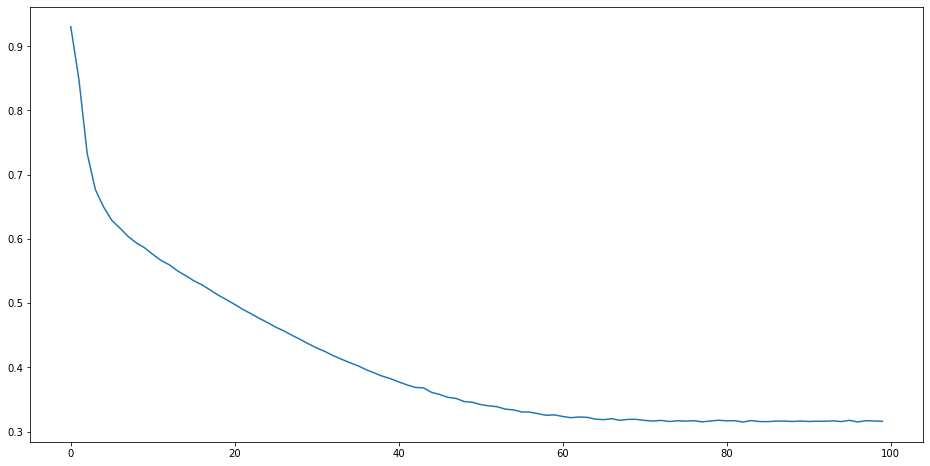

In [857]:
plt.figure(figsize=(16,8))
plt.plot(history.history['val_root_mean_squared_error'])
plt.show()

In [858]:
np.argmin(history.history['val_root_mean_squared_error'])

82

In [1714]:
y_pred = model4.predict(x_test)

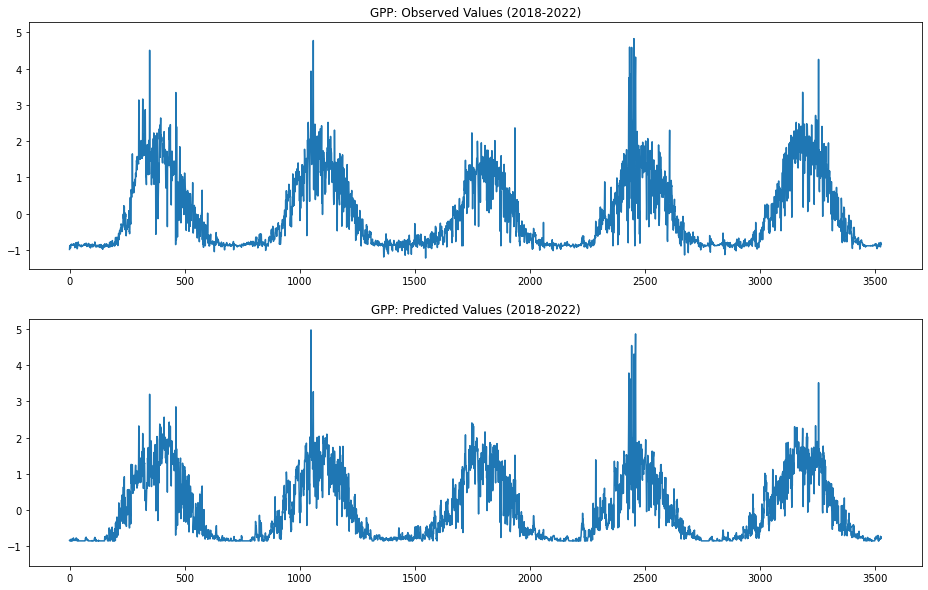

In [1715]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16,10), sharey=True)

ax[0].plot(y_test)
ax[0].set_title('GPP: Observed Values (2018-2022)')

ax[1].plot(y_pred)
ax[1].set_title('GPP: Predicted Values (2018-2022)')

plt.show()

In [1716]:
residuals = y_test - y_pred.flatten()
res_r = list(range(len(residuals)))

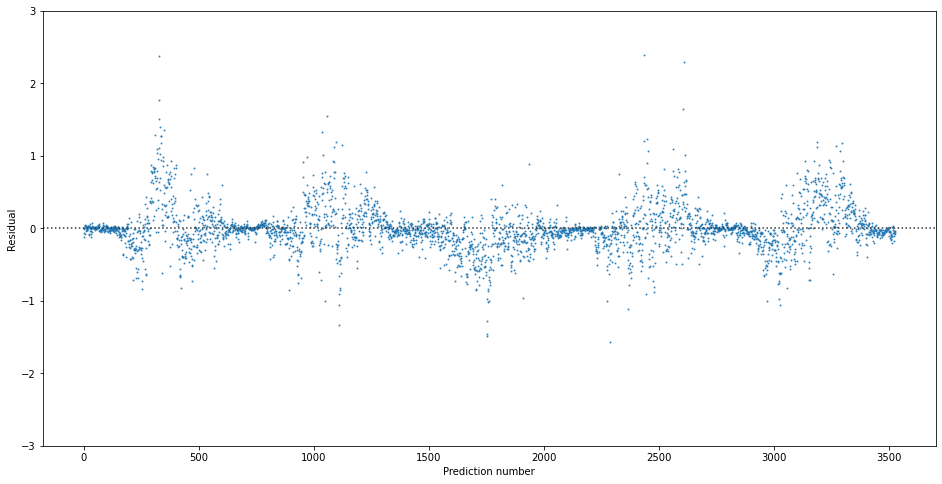

In [863]:
fig = plt.figure(figsize=(16,8))
sns.residplot(x=res_r, y=residuals, scatter_kws=dict(s=1))
plt.xlabel('Prediction number')
plt.ylabel('Residual')
plt.ylim(-3,3)
plt.show()

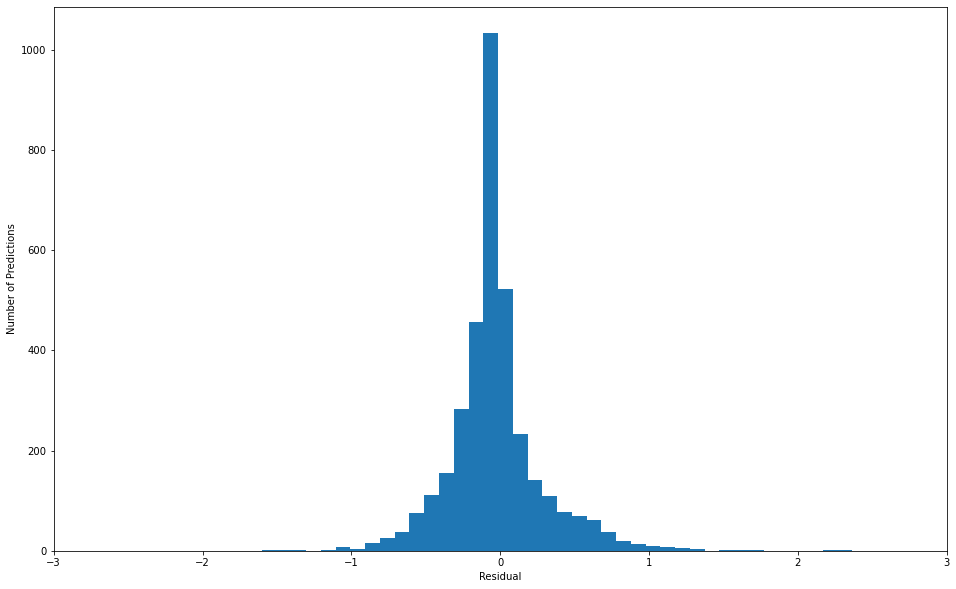

In [1717]:
fig = plt.figure(figsize=(16,10))
plt.hist(residuals, bins=40)
plt.ylabel('Number of Predictions')
plt.xlabel('Residual')
plt.xlim(-3,3)
plt.show()

## 6 hour LSTM

The below sections combine the 6 hour and 12 hour averaged datasets with the LSTM to see if these datasets have any positive effect on the performance of the model

In [1718]:
df_6h_stand = scaler.fit_transform(df_6h)

In [1719]:
X, y = df_to_lstm(df_6h_stand)

In [1720]:
X.shape, y.shape

((28068, 5, 5), (28068,))

In [1721]:
x_train = X[:math.floor(len(X)*perc_split)]
x_test = X[math.floor(len(X)*perc_split):]

x_train.shape, x_test.shape

((21051, 5, 5), (7017, 5, 5))

In [1722]:
y_train = y[:math.floor(len(y)*perc_split)]
y_test = y[math.floor(len(y)*perc_split):]

y_train.shape, y_test.shape

((21051,), (7017,))

In [870]:
model5 = Sequential()
model5.add(InputLayer((5,5)))
model5.add(LSTM(64, activation=None))
model5.add(Dense(32, activation='relu'))
model5.add(Dense(16, activation='relu'))
model5.add(Dense(8, activation='relu'))
model5.add(Dense(4, activation='relu'))
model5.add(Dense(1, activation='linear'))

model5.compile(loss='MeanSquaredError', optimizer=Adam(learning_rate=0.0001), metrics=['RootMeanSquaredError'])

In [871]:
history = model5.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=128)

Epoch 1/100
165/165 [==============================] - 1s 3ms/step - loss: 0.8607 - root_mean_squared_error: 0.9277 - val_loss: 0.6524 - val_root_mean_squared_error: 0.8077
Epoch 2/100
165/165 [==============================] - 0s 2ms/step - loss: 0.6082 - root_mean_squared_error: 0.7799 - val_loss: 0.5108 - val_root_mean_squared_error: 0.7147
Epoch 3/100
165/165 [==============================] - 0s 2ms/step - loss: 0.4868 - root_mean_squared_error: 0.6977 - val_loss: 0.4346 - val_root_mean_squared_error: 0.6593
Epoch 4/100
165/165 [==============================] - 0s 2ms/step - loss: 0.4053 - root_mean_squared_error: 0.6366 - val_loss: 0.3777 - val_root_mean_squared_error: 0.6146
Epoch 5/100
165/165 [==============================] - 0s 2ms/step - loss: 0.3372 - root_mean_squared_error: 0.5807 - val_loss: 0.3296 - val_root_mean_squared_error: 0.5741
Epoch 6/100
165/165 [==============================] - 0s 2ms/step - loss: 0.2837 - root_mean_squared_error: 0.5327 - val_loss: 0.2909 

165/165 [==============================] - 0s 2ms/step - loss: 0.1166 - root_mean_squared_error: 0.3415 - val_loss: 0.1520 - val_root_mean_squared_error: 0.3898
Epoch 49/100
165/165 [==============================] - 0s 2ms/step - loss: 0.1158 - root_mean_squared_error: 0.3403 - val_loss: 0.1526 - val_root_mean_squared_error: 0.3906
Epoch 50/100
165/165 [==============================] - 0s 2ms/step - loss: 0.1158 - root_mean_squared_error: 0.3402 - val_loss: 0.1511 - val_root_mean_squared_error: 0.3888
Epoch 51/100
165/165 [==============================] - 0s 2ms/step - loss: 0.1150 - root_mean_squared_error: 0.3391 - val_loss: 0.1509 - val_root_mean_squared_error: 0.3884
Epoch 52/100
165/165 [==============================] - 0s 2ms/step - loss: 0.1144 - root_mean_squared_error: 0.3383 - val_loss: 0.1501 - val_root_mean_squared_error: 0.3874
Epoch 53/100
165/165 [==============================] - 0s 2ms/step - loss: 0.1142 - root_mean_squared_error: 0.3380 - val_loss: 0.1497 - val_r

165/165 [==============================] - 0s 2ms/step - loss: 0.1019 - root_mean_squared_error: 0.3192 - val_loss: 0.1432 - val_root_mean_squared_error: 0.3785
Epoch 96/100
165/165 [==============================] - 0s 2ms/step - loss: 0.1020 - root_mean_squared_error: 0.3193 - val_loss: 0.1420 - val_root_mean_squared_error: 0.3768
Epoch 97/100
165/165 [==============================] - 0s 2ms/step - loss: 0.1018 - root_mean_squared_error: 0.3191 - val_loss: 0.1415 - val_root_mean_squared_error: 0.3762
Epoch 98/100
165/165 [==============================] - 0s 2ms/step - loss: 0.1014 - root_mean_squared_error: 0.3184 - val_loss: 0.1417 - val_root_mean_squared_error: 0.3765
Epoch 99/100
165/165 [==============================] - 0s 2ms/step - loss: 0.1010 - root_mean_squared_error: 0.3178 - val_loss: 0.1449 - val_root_mean_squared_error: 0.3807
Epoch 100/100
165/165 [==============================] - 0s 2ms/step - loss: 0.1008 - root_mean_squared_error: 0.3174 - val_loss: 0.1429 - val_

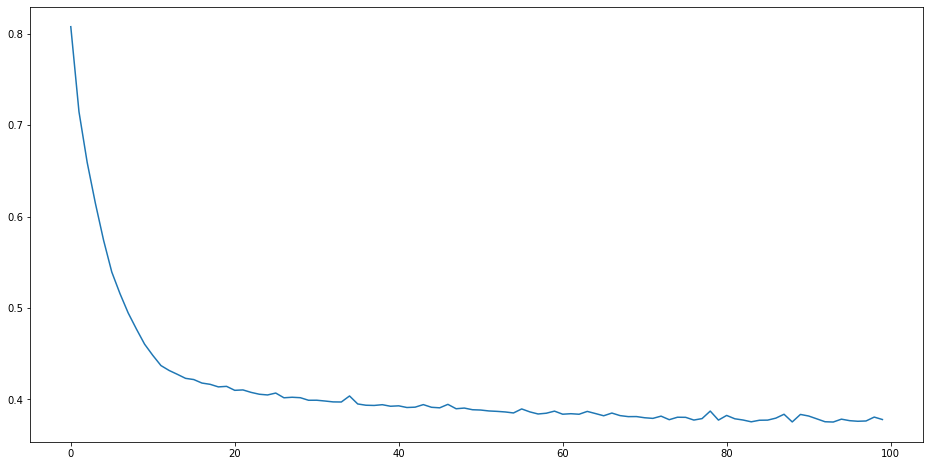

In [872]:
plt.figure(figsize=(16,8))
plt.plot(history.history['val_root_mean_squared_error'])
plt.show()

In [873]:
np.argmin(history.history['val_root_mean_squared_error'])

93

In [1723]:
y_pred = model5.predict(x_test)

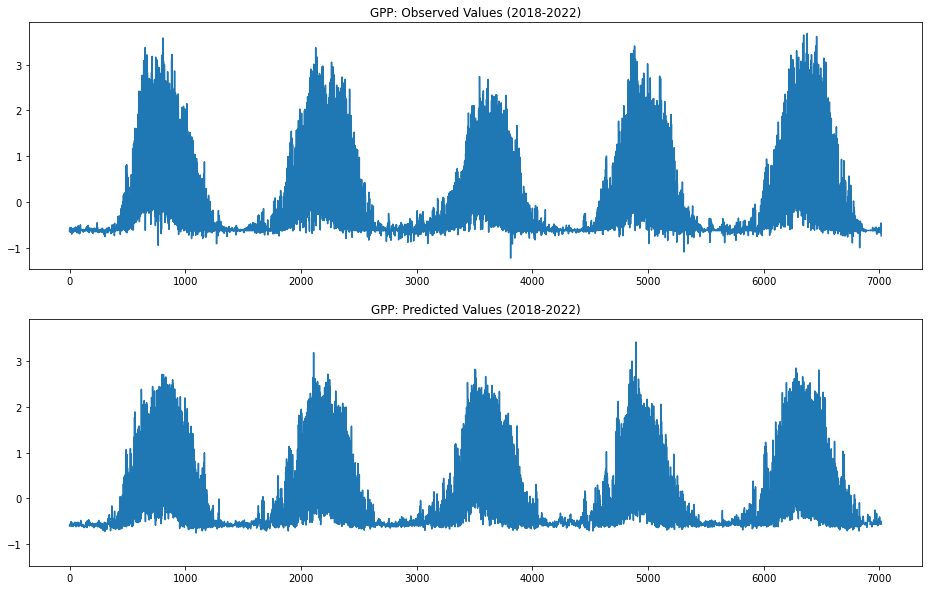

In [1724]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16,10), sharey=True)

ax[0].plot(y_test)
ax[0].set_title('GPP: Observed Values (2018-2022)')

ax[1].plot(y_pred)
ax[1].set_title('GPP: Predicted Values (2018-2022)')

plt.show()

In [1725]:
residuals = y_test - y_pred.flatten()
res_r = list(range(len(residuals)))

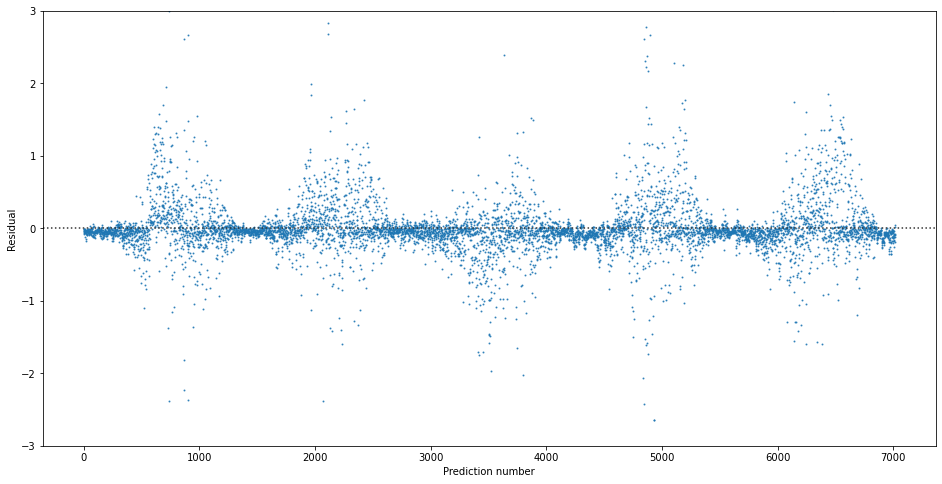

In [877]:
fig = plt.figure(figsize=(16,8))
sns.residplot(x=res_r, y=residuals, scatter_kws=dict(s=1))
plt.xlabel('Prediction number')
plt.ylabel('Residual')
plt.ylim(-3,3)
plt.show()

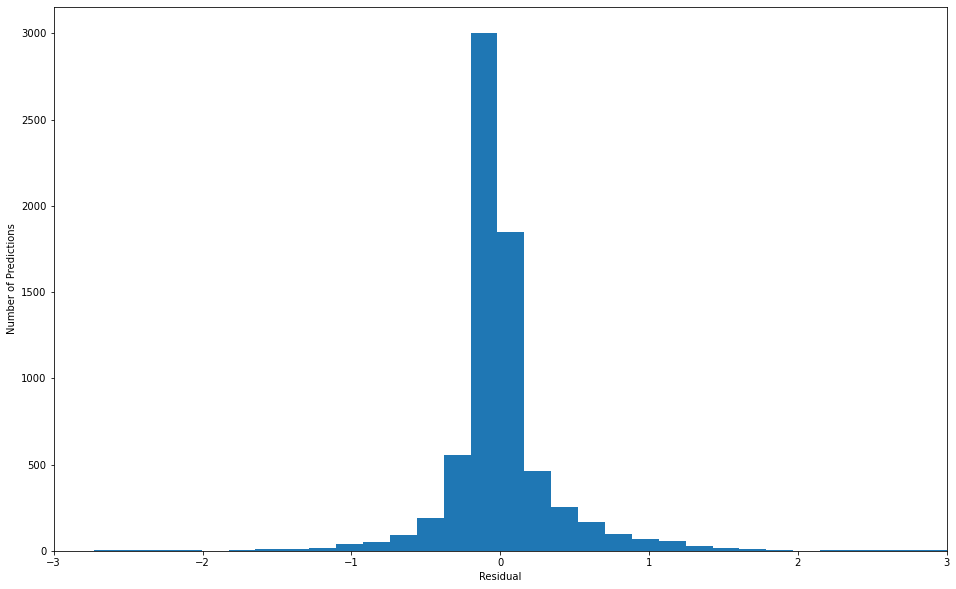

In [1726]:
fig = plt.figure(figsize=(16,10))
plt.hist(residuals, bins=40)
plt.ylabel('Number of Predictions')
plt.xlabel('Residual')
plt.xlim(-3,3)
plt.show()

### 12 hour LSTM

In [1727]:
df_12h_stand = scaler.fit_transform(df_12h)

In [1728]:
X, y = df_to_lstm(df_12h_stand)

In [1729]:
X.shape, y.shape

((14101, 5, 5), (14101,))

In [1730]:
x_train = X[:math.floor(len(X)*perc_split)]
x_test = X[math.floor(len(X)*perc_split):]

x_train.shape, x_test.shape

((10575, 5, 5), (3526, 5, 5))

In [1731]:
y_train = y[:math.floor(len(y)*perc_split)]
y_test = y[math.floor(len(y)*perc_split):]

y_train.shape, y_test.shape

((10575,), (3526,))

In [884]:
model6 = Sequential()
model6.add(InputLayer((5,5)))
model6.add(LSTM(64, activation=None))
model6.add(Dense(32, activation='relu'))
model6.add(Dense(16, activation='relu'))
model6.add(Dense(8, activation='relu'))
model6.add(Dense(4, activation='relu'))
model6.add(Dense(1, activation='linear'))

model6.compile(loss='MeanSquaredError', optimizer=Adam(learning_rate=0.0001), metrics=['RootMeanSquaredError'])

In [885]:
history = model6.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=128)

Epoch 1/100
83/83 [==============================] - 1s 4ms/step - loss: 0.9336 - root_mean_squared_error: 0.9662 - val_loss: 0.8064 - val_root_mean_squared_error: 0.8980
Epoch 2/100
83/83 [==============================] - 0s 2ms/step - loss: 0.6776 - root_mean_squared_error: 0.8232 - val_loss: 0.5677 - val_root_mean_squared_error: 0.7535
Epoch 3/100
83/83 [==============================] - 0s 2ms/step - loss: 0.4215 - root_mean_squared_error: 0.6492 - val_loss: 0.3405 - val_root_mean_squared_error: 0.5835
Epoch 4/100
83/83 [==============================] - 0s 2ms/step - loss: 0.2636 - root_mean_squared_error: 0.5134 - val_loss: 0.2819 - val_root_mean_squared_error: 0.5309
Epoch 5/100
83/83 [==============================] - 0s 2ms/step - loss: 0.2172 - root_mean_squared_error: 0.4661 - val_loss: 0.2519 - val_root_mean_squared_error: 0.5019
Epoch 6/100
83/83 [==============================] - 0s 2ms/step - loss: 0.1981 - root_mean_squared_error: 0.4451 - val_loss: 0.2373 - val_root_m

Epoch 49/100
83/83 [==============================] - 0s 2ms/step - loss: 0.1497 - root_mean_squared_error: 0.3869 - val_loss: 0.1941 - val_root_mean_squared_error: 0.4406
Epoch 50/100
83/83 [==============================] - 0s 2ms/step - loss: 0.1492 - root_mean_squared_error: 0.3863 - val_loss: 0.1934 - val_root_mean_squared_error: 0.4397
Epoch 51/100
83/83 [==============================] - 0s 2ms/step - loss: 0.1485 - root_mean_squared_error: 0.3854 - val_loss: 0.1947 - val_root_mean_squared_error: 0.4413
Epoch 52/100
83/83 [==============================] - 0s 2ms/step - loss: 0.1488 - root_mean_squared_error: 0.3858 - val_loss: 0.1932 - val_root_mean_squared_error: 0.4396
Epoch 53/100
83/83 [==============================] - 0s 2ms/step - loss: 0.1480 - root_mean_squared_error: 0.3847 - val_loss: 0.1929 - val_root_mean_squared_error: 0.4392
Epoch 54/100
83/83 [==============================] - 0s 2ms/step - loss: 0.1482 - root_mean_squared_error: 0.3849 - val_loss: 0.1919 - val_

83/83 [==============================] - 0s 2ms/step - loss: 0.1425 - root_mean_squared_error: 0.3775 - val_loss: 0.1946 - val_root_mean_squared_error: 0.4411
Epoch 97/100
83/83 [==============================] - 0s 2ms/step - loss: 0.1428 - root_mean_squared_error: 0.3779 - val_loss: 0.1915 - val_root_mean_squared_error: 0.4377
Epoch 98/100
83/83 [==============================] - 0s 2ms/step - loss: 0.1428 - root_mean_squared_error: 0.3779 - val_loss: 0.1958 - val_root_mean_squared_error: 0.4425
Epoch 99/100
83/83 [==============================] - 0s 2ms/step - loss: 0.1424 - root_mean_squared_error: 0.3774 - val_loss: 0.1922 - val_root_mean_squared_error: 0.4385
Epoch 100/100
83/83 [==============================] - 0s 2ms/step - loss: 0.1425 - root_mean_squared_error: 0.3775 - val_loss: 0.1933 - val_root_mean_squared_error: 0.4397


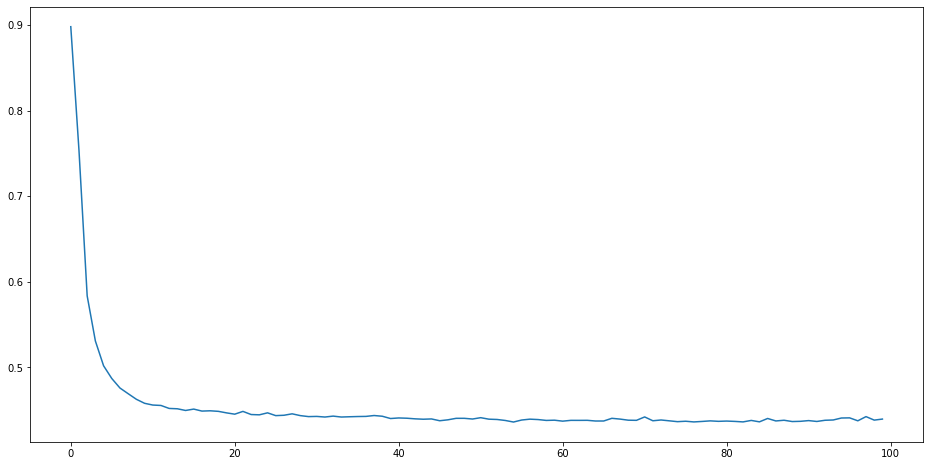

In [886]:
plt.figure(figsize=(16,8))
plt.plot(history.history['val_root_mean_squared_error'])
plt.show()

In [887]:
np.argmin(history.history['val_root_mean_squared_error'])

54

In [1732]:
y_pred = model6.predict(x_test)

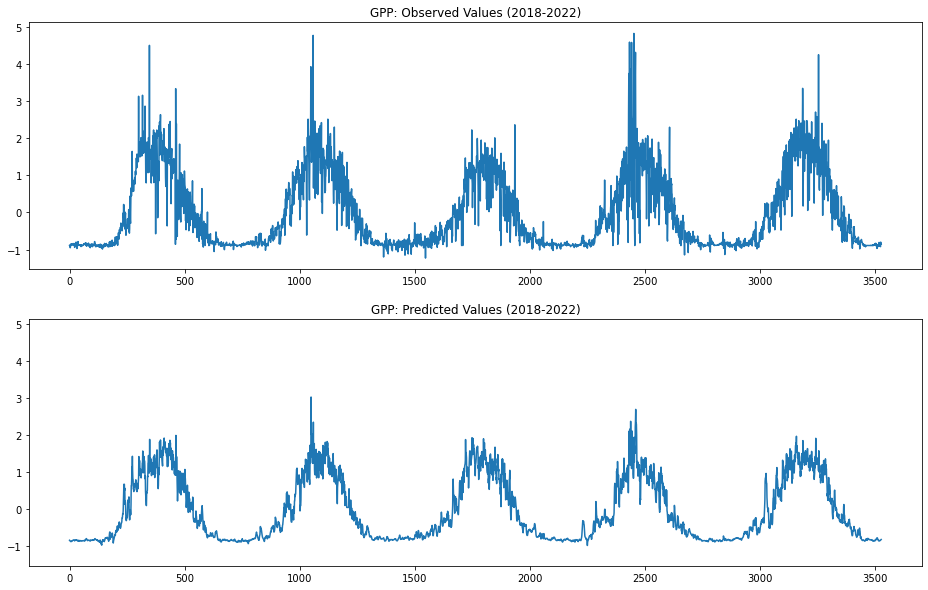

In [1733]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16,10), sharey=True)

ax[0].plot(y_test)
ax[0].set_title('GPP: Observed Values (2018-2022)')

ax[1].plot(y_pred)
ax[1].set_title('GPP: Predicted Values (2018-2022)')

plt.show()

In [1734]:
residuals = y_test - y_pred.flatten()
res_r = list(range(len(residuals)))

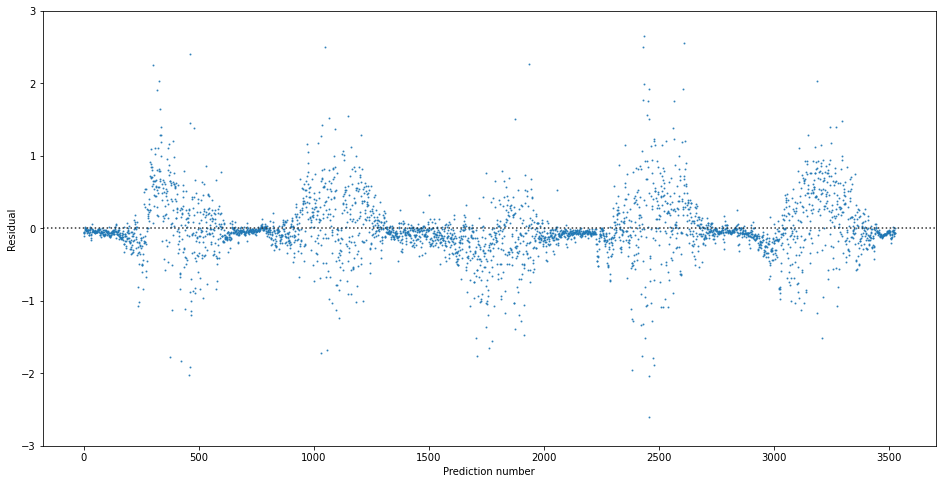

In [891]:
fig = plt.figure(figsize=(16,8))
sns.residplot(x=res_r, y=residuals, scatter_kws=dict(s=1))
plt.xlabel('Prediction number')
plt.ylabel('Residual')
plt.ylim(-3,3)
plt.show()

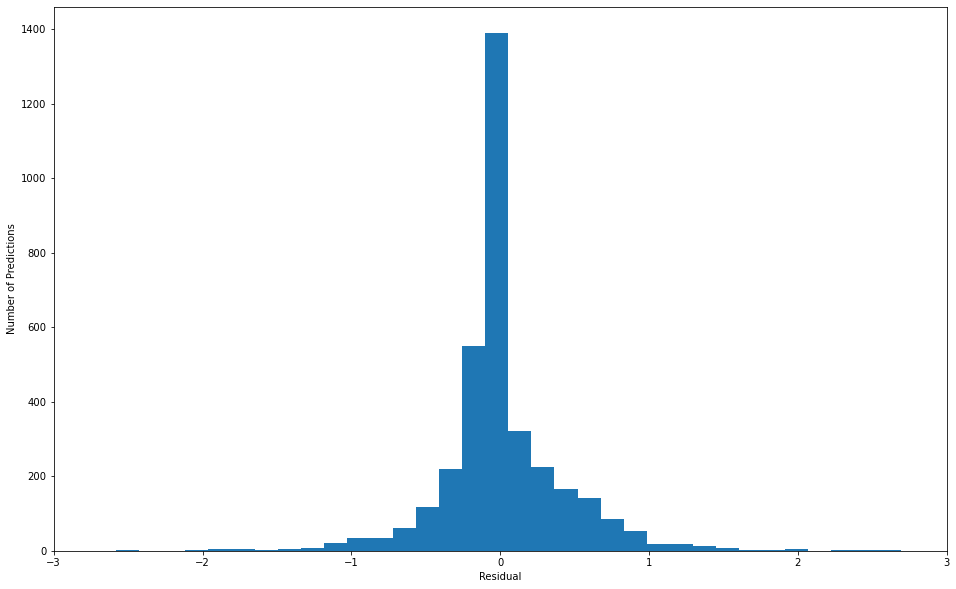

In [1735]:
fig = plt.figure(figsize=(16,10))
plt.hist(residuals, bins=40)
plt.ylabel('Number of Predictions')
plt.xlabel('Residual')
plt.xlim(-3,3)
plt.show()

# 6 hour average model optimisation

Based on our testing, the 6-hour averaged dataset on the regular densely connected network performed the best. In this section we will tune this model further to attempt to squeeze out some more performance

In [1651]:
df_stand = scaler.fit_transform(df_6h)

In [1652]:
x_train = df_stand[:, 0:5][:math.floor(len(df_stand)*perc_split)]
x_test = df_stand[:, 0:5][math.floor(len(df_stand)*perc_split):]

x_train.shape, x_test.shape

((21054, 5), (7019, 5))

In [1653]:
y_train = df_stand[:, 5][:math.floor(len(df_stand)*perc_split)]
y_test = df_stand[:, 5][math.floor(len(df_stand)*perc_split):]

y_train.shape, y_test.shape

((21054,), (7019,))

Below we define a function that builds a model. It takes an argument 'hp' which refers to the hyperparameters. However, rather than specifying an exact value for neurons per layer, how many hidden layers, learning rate, and amount of dropout, we instead specify ranges for each that we want to test. For example, for the first hidden layer we have:

    (hp.Int("input_units", 32, 256, 32)
    
This specifies that we want to pick a number of neurons ranging from 32 to 256, with a step size of 32. For dropout:

    (Dropout(hp.Float('dropout_1', 0, 0.5, 0.1))
   
Specifies an amount of dropout ranging from 0 to 0.5 (50%), with a step size of 0.1. We also select a number of additional hidden layers at random ranging from 1 to 4

In [901]:
def build_model(hp):
    model = Sequential()
    
    model.add(Dense(hp.Int("input_units", 32, 256, 32), input_shape=(5,), activation='relu'))
    
    model.add(Dropout(hp.Float('dropout_1', 0, 0.5, 0.1)))
    
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(Dense(hp.Int(f"layer_{i}_units", 32, 256, 32), activation='relu'))
        
        model.add(Dropout(hp.Float('dropout_{i + 2}', 0, 0.5, 0.1)))
        
    model.add(Dense(1, activation='linear'))

    hp_learning_rate = hp.Choice('learning_rate', values = [0.01, 0.001, 0.0001])
    
    model.compile(loss='MeanSquaredError', optimizer=Adam(learning_rate=hp_learning_rate), metrics=['RootMeanSquaredError'])
    
    return model

The tuner search outputs a model for each of the trials, so we need somewhere to save all of these tuner objects. Here we just create a folder with the current timestamp.

In [905]:
LOG_DIR = 'TunerModels'

Here's where we define the parameters for the search. We provide the function that builds the model (build_model), the objective which we define as minimizing the validation root mean squared error, the number of models to build (trials), the number of models to build per trial, and the directory to save all of the models tuner objects.

In [906]:
tuner = RandomSearch(
    build_model, 
    objective = kerastuner.Objective('val_root_mean_squared_error', direction='min'),
    max_trials = 100,
    executions_per_trial = 1,
    directory = LOG_DIR
)

Initiate the search, providing training data, number of epochs, batch_size and validation sets as before

In [907]:
tuner.search(x=x_train, y=y_train, epochs=100, batch_size=128, validation_data=(x_test, y_test))

Trial 100 Complete [00h 00m 21s]
val_root_mean_squared_error: 0.25294339656829834

Best val_root_mean_squared_error So Far: 0.2508019804954529
Total elapsed time: 00h 52m 01s


In [940]:
model = tuner.get_best_models()[0]

In [923]:
tuner.get_best_hyperparameters()[0].values

{'input_units': 224,
 'dropout_1': 0.30000000000000004,
 'n_layers': 2,
 'layer_0_units': 224,
 'dropout_{i + 2}': 0.30000000000000004,
 'learning_rate': 0.001,
 'layer_1_units': 224,
 'layer_2_units': 256,
 'layer_3_units': 64}

In [1654]:
y_pred = model.predict(x_test)

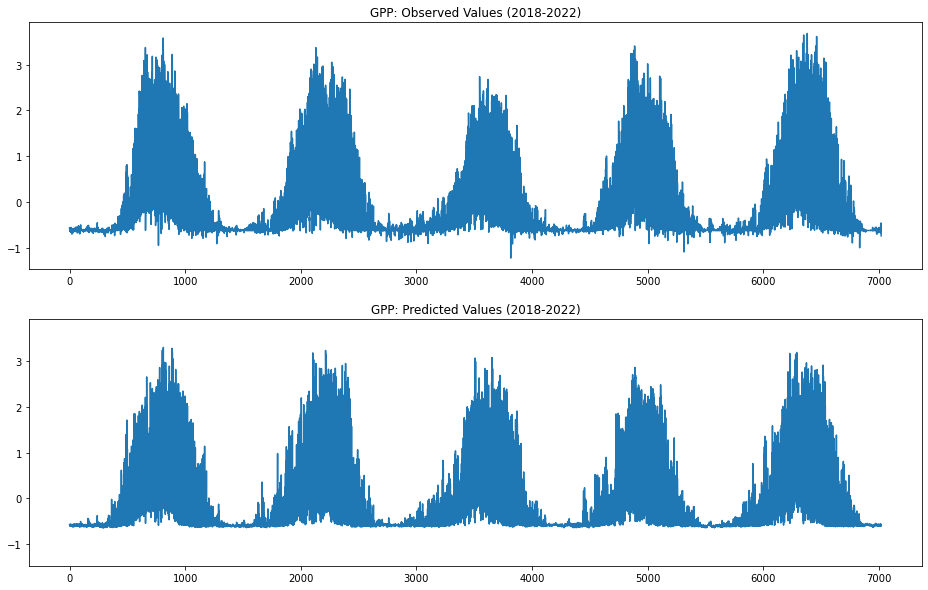

In [1661]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16,10), sharey=True)

ax[0].plot(y_test)
ax[0].set_title('GPP: Observed Values (2018-2022)')

ax[1].plot(y_pred)
ax[1].set_title('GPP: Predicted Values (2018-2022)')

plt.show()

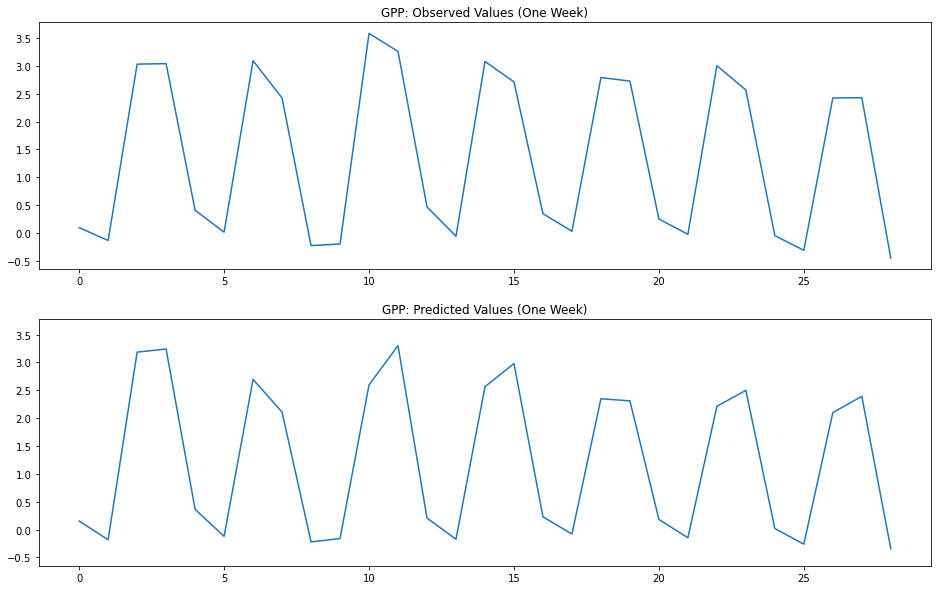

In [1660]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16,10), sharey=True)

ax[0].plot(y_test[800:829])
ax[0].set_title('GPP: Observed Values (One Week)')

ax[1].plot(y_pred[800:829])
ax[1].set_title('GPP: Predicted Values (One Week)')

plt.show()

In [960]:
residuals = y_test - y_pred.flatten()
res_r = list(range(len(residuals)))

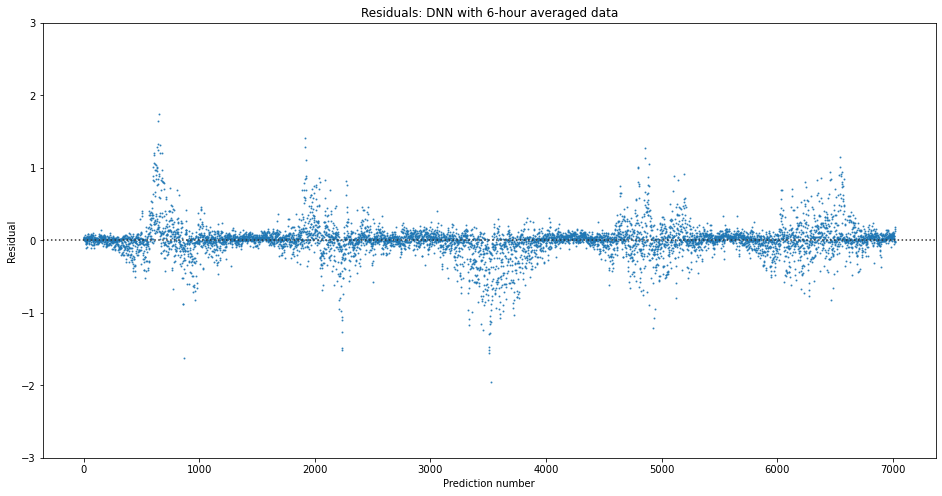

In [1615]:
fig = plt.figure(figsize=(16,8))
sns.residplot(x=res_r, y=residuals, scatter_kws=dict(s=1))
plt.title('Residuals: DNN with 6-hour averaged data')
plt.xlabel('Prediction number')
plt.ylabel('Residual')
plt.ylim(-3,3)
plt.show()

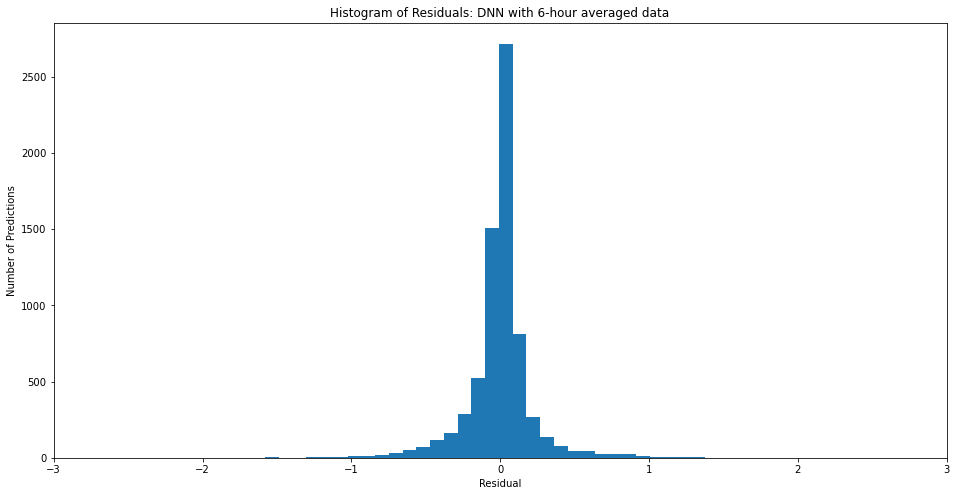

In [1618]:
fig = plt.figure(figsize=(16,8))
plt.hist(residuals, bins=40)
plt.xlim(-3,3)
plt.title('Histogram of Residuals: DNN with 6-hour averaged data')
plt.xlabel('Residual')
plt.ylabel('Number of Predictions')
plt.show()

In [947]:
math.sqrt(sum(abs(residuals*residuals)) / len(residuals))

0.25080198697068734

## XGBoost Baseline model

Here we train the baseline XGBoost regressor. This method combines the output of many individual decision trees to create a prediction. Given our best performing model was on the 6 hour averaged dataset, we will use this same dataset for the XGBoost model

In [1736]:
scaler = StandardScaler()
df_stand = scaler.fit_transform(df_6h)

In [1737]:
x_train = df_stand[:, 0: -1][:math.floor(len(df_stand)*perc_split)]
x_test = df_stand[:, 0: -1][math.floor(len(df_stand)*perc_split):]

x_train.shape, x_test.shape

((21054, 5), (7019, 5))

In [1738]:
y_train = df_stand[:, -1][:math.floor(len(df_stand)*perc_split)]
y_test = df_stand[:, -1][math.floor(len(df_stand)*perc_split):]

y_train.shape, y_test.shape

((21054,), (7019,))

Create and train the XGBoost regressor. n_estimators specifies the number of individual trees to create, while early_stopping_rounds stops training once no improvements are found after 50 iterations, which can help avoid overfitting

In [952]:
xgb_model = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)
xgb_model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], verbose=50)

[0]	validation_0-rmse:1.00155	validation_1-rmse:0.95700
[50]	validation_0-rmse:0.64025	validation_1-rmse:0.59591
[100]	validation_0-rmse:0.43306	validation_1-rmse:0.40695
[150]	validation_0-rmse:0.31957	validation_1-rmse:0.31952
[200]	validation_0-rmse:0.26080	validation_1-rmse:0.28397
[250]	validation_0-rmse:0.23181	validation_1-rmse:0.27015
[300]	validation_0-rmse:0.21675	validation_1-rmse:0.26510
[350]	validation_0-rmse:0.20838	validation_1-rmse:0.26465
[374]	validation_0-rmse:0.20572	validation_1-rmse:0.26525


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Create and plot predictions based on the testing data

In [1739]:
y_pred = xgb_model.predict(x_test)

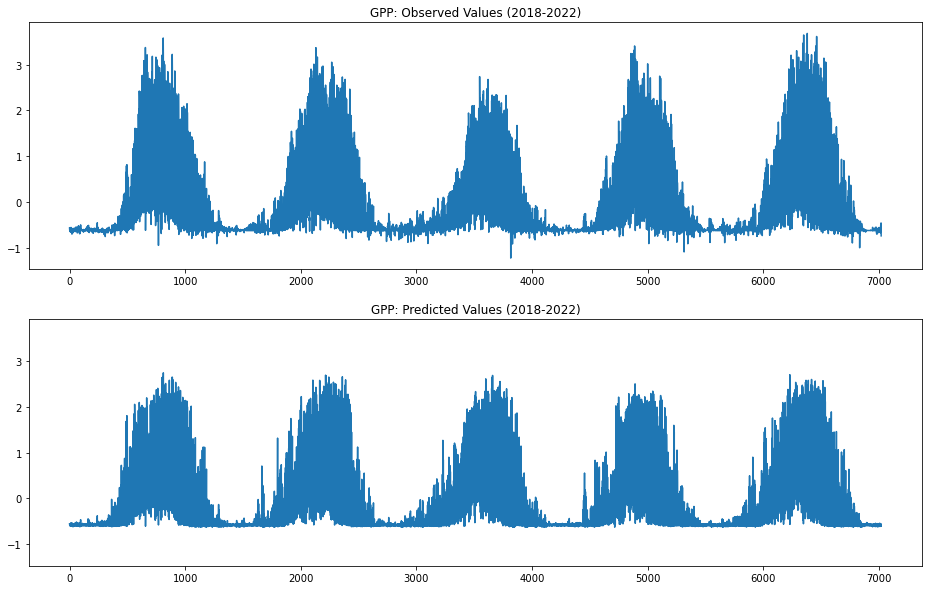

In [1740]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16,10), sharey=True)

ax[0].plot(y_test)
ax[0].set_title('GPP: Observed Values (2018-2022)')

ax[1].plot(y_pred)
ax[1].set_title('GPP: Predicted Values (2018-2022)')

plt.show()

In [1741]:
residuals = y_test - y_pred.flatten()
res_r = list(range(len(residuals)))

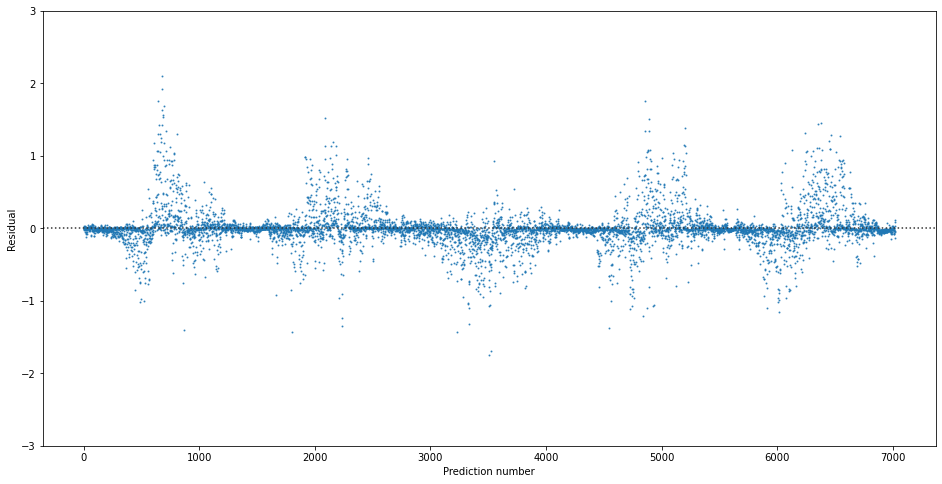

In [967]:
fig = plt.figure(figsize=(16,8))
sns.residplot(x=res_r, y=residuals, scatter_kws=dict(s=1))
plt.xlabel('Prediction number')
plt.ylabel('Residual')
plt.ylim(-3,3)
plt.show()

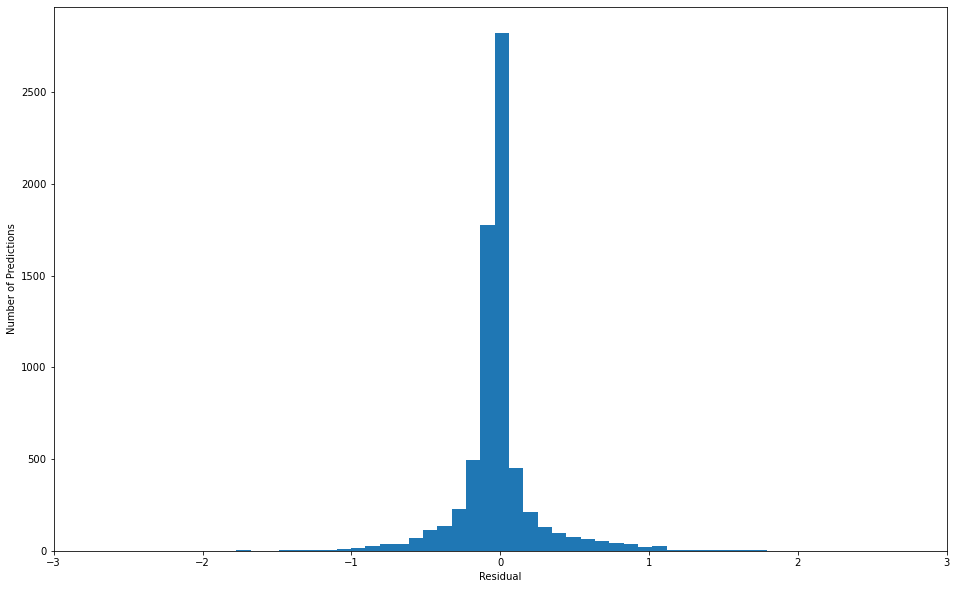

In [1742]:
fig = plt.figure(figsize=(16,10))
plt.hist(residuals, bins=40)
plt.ylabel('Number of Predictions')
plt.xlabel('Residual')
plt.xlim(-3,3)
plt.show()

# Performance Table

In [1199]:
rsmes = {'1 Hour': {'Dense': 0.2868, 'LSTM': 0.3373}, '6 Hour': {'Dense': 0.2579, 'LSTM': 0.3753}, '12 Hour': {'Dense': 0.3149, 'LSTM': 0.4362}, '6 Hour Optimized': {'Dense': 0.2508, 'LSTM': np.nan}}
rmse_df = pd.DataFrame(rsmes)
rmse_df

,1 Hour,6 Hour,12 Hour,6 Hour Optimized
Dense,0.2868,0.2579,0.3149,0.2508
LSTM,0.3373,0.3753,0.4362,NaN


# Predictions

Now that we have a model, we can create some predictions for the future! For this, we will take values at the height of the day during the months of July, as this is when GPP is at its peak. We will create normal distributions to sample data we can create predictions with, and play around with values to see how they affect the prediction

Create 2 more scaler objects, one for the predictor features and one for the target feature. We separate these so that we can inverse the scaler on the target predictions to get back to a raw value of GPP

In [1662]:
pscaler = StandardScaler()
tscaler = StandardScaler()
predscaler = pscaler.fit(df_6h.iloc[:, 0:5])
targetscaler = tscaler.fit(df_6h.iloc[:, 5].values.reshape(-1, 1))

Here we are putting out all samples that in are July across the whole dataset, and futher filtering that to only include values between the times of 11am and 3pm

In [1663]:
july_data = df[(df.index.month == 7) & (df.index.hour >= 11) & (df.index.hour <= 15)]

In [1664]:
july_data

,Air Temp,PAR,NOx Conc. 33m,CO2 Concentration,Rel. Humidity,GPP
Timestamp,,,,,,
2003-07-01 11:00:00,18.54117,1237.69667,0.66600,356.89000,61.44183,26.8900
2003-07-01 12:00:00,19.20917,1158.60417,0.68000,356.97600,58.98517,19.0705
2003-07-01 13:00:00,19.66952,804.98104,0.78286,357.18857,57.78595,15.9070
2003-07-01 14:00:00,20.11300,520.53576,0.76400,357.02300,56.61550,14.7570
2003-07-01 15:00:00,20.46917,782.95933,0.80900,356.75500,55.48950,18.7115
...,...,...,...,...,...,...
2022-07-31 11:00:00,18.44433,1440.72152,0.27100,394.73900,51.13496,14.7090
2022-07-31 12:00:00,18.49783,816.82026,0.25900,393.49420,56.49552,19.1940
2022-07-31 13:00:00,18.36633,1051.00367,0.25000,393.34760,63.86197,20.7975


Calculate the mean and standard deviation for each feature in the july_data subset

In [1665]:
means = np.mean(july_data)
st_dev = np.std(july_data)

In [1666]:
print(means, '\n', st_dev)

Air Temp              19.008748
PAR                  930.125046
NOx Conc. 33m          0.432129
CO2 Concentration    382.661896
Rel. Humidity         58.971379
GPP                   16.464569
dtype: float64 
 Air Temp               4.188040
PAR                  398.677302
NOx Conc. 33m          0.439982
CO2 Concentration     14.110125
Rel. Humidity         18.129236
GPP                    4.715084
dtype: float64


Here we define a function that generates samples of data based on the observed mean and standard deviation of each feature. We also specify the co2 mean and deviation seperately so that we can investigate the effects of changing this on our predictions, and we can also add a warming amoumt, which adds an constant to the temperate distribution.

In [1508]:
def generate_vals(means, st_dev, co2_mean, co2_std, warming, size):
    air_temp = np.random.normal(means['Air Temp'] + warming, st_dev['Air Temp'], size)
    par = np.random.normal(means['PAR'], st_dev['PAR'], size)
    nox_conc = np.random.normal(means['NOx Conc. 33m'], st_dev['NOx Conc. 33m'], size)
    rel_hum = np.random.normal(means['Rel. Humidity'], st_dev['Rel. Humidity'], size)
    co2_conc = np.random.normal(co2_mean, co2_std, size)
    
    return np.array([air_temp, par, nox_conc, co2_conc, rel_hum]).T

We also take a sample of GPP values from a normal distribution. These will act as our values to compare our predictions against

In [1669]:
gpp = np.random.normal(means['GPP'], st_dev['GPP'], 200)

Generate 200 data samples from the defined function above, using NASAs 2040 estimate of 450ppm CO2 concentration, and a 0.5c warming

In [1670]:
vals = generate_vals(means=means, st_dev=st_dev, co2_mean=450, co2_std=15, warming=0.5, size=200)

Scale the values using the predscaler to standardize them 

In [1671]:
vals = predscaler.transform(vals)

G:\ProgramData\Python\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


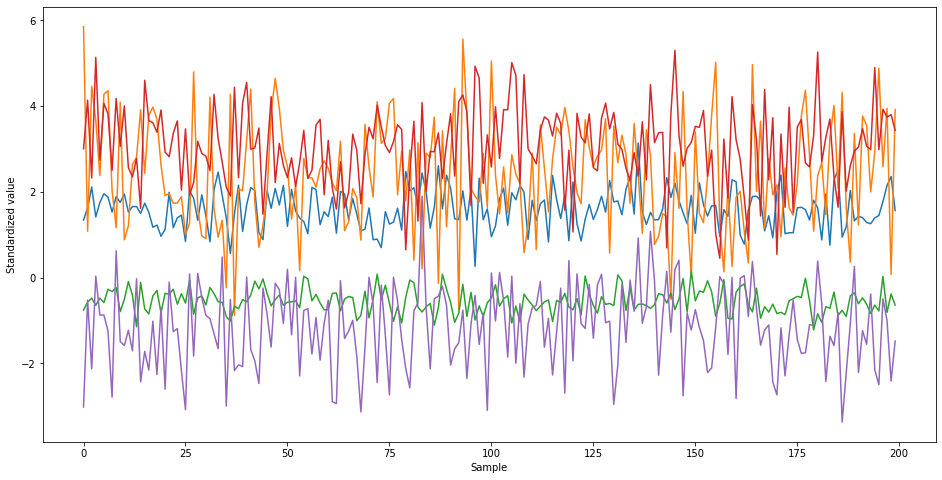

In [1672]:
fig = plt.figure(figsize=(16,8))
plt.plot(vals)
plt.xlabel('Sample')
plt.ylabel('Standardized value')
plt.show()

In [1673]:
vals.shape

(200, 5)

Create predictions from the model using the generating values

In [1674]:
predictions = model.predict(vals)

The prediction generates values in the standardized range. We can inverse these using our targetscaler to return to the raw GPP values

In [1675]:
inv = targetscaler.inverse_transform(predictions)

Compare actual GPP vals here

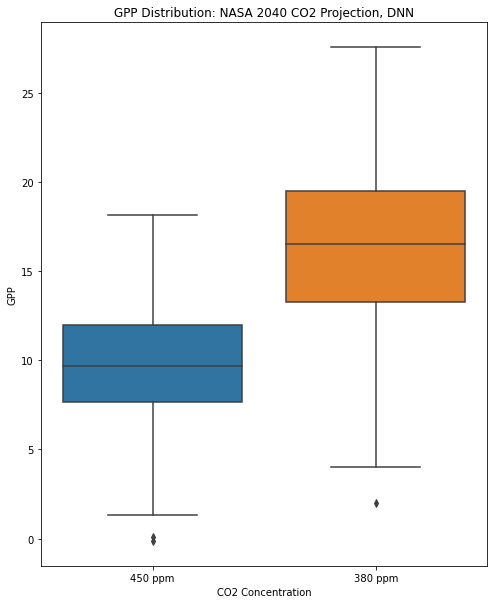

In [1676]:
fig = plt.figure(figsize=(8,10))
box = sns.boxplot(data=[inv, gpp], orient='l')
box.set_xticklabels(['450 ppm', '380 ppm'])
plt.title('GPP Distribution: NASA 2040 CO2 Projection, DNN')
plt.xlabel('CO2 Concentration')
plt.ylabel('GPP')
plt.show()

Here we conduct a t-test to see if there is a statistically significant difference between the 2 distributions

In [1517]:
from scipy.stats import ttest_ind

In [1677]:
t_stat, p_value = ttest_ind(inv, gpp)
alpha = 0.05

if p_value < alpha:
     print("Reject the null hypothesis; there is a significant difference between the sample mean and the hypothesized population mean at the 95% confidence level.")
else:
    print("Fail to reject the null hypothesis; there is no significant difference between the sample mean and the hypothesized population mean at the 95% confidence level.")

Reject the null hypothesis; there is a significant difference between the sample mean and the hypothesized population mean at the 95% confidence level.


In [1678]:
print(p_value)

[7.60646306e-50]


# Predictions including Month

For these predictions, we add a features of the month and hour of the day to the dataframe in order to give the model more information about the state of the sample

In [1568]:
df2 = df_6h.copy()
df2['month'] = df_6h.index.month
df2['hour'] = df_6h.index.hour

In [1569]:
df2

,Air Temp,PAR,NOx Conc. 33m,CO2 Concentration,Rel. Humidity,GPP,month,hour
Timestamp,,,,,,,,
2003-01-01 00:00:00,-23.500915,0.099682,1.098333,381.377167,99.304640,0.000000,1,0
2003-01-01 06:00:00,-22.564250,27.646777,0.634000,382.330500,97.263417,0.000000,1,6
2003-01-01 12:00:00,-20.128248,40.694417,1.821833,382.230333,95.092602,0.000000,1,12
2003-01-01 18:00:00,-21.141057,0.049945,1.581667,382.758167,95.271193,0.000000,1,18
2003-01-02 00:00:00,-21.530888,-0.024222,1.330333,382.721500,95.479867,0.000000,1,0
...,...,...,...,...,...,...,...,...
2022-12-30 18:00:00,1.311917,-0.078265,0.753833,427.512367,99.283752,0.534250,12,18
2022-12-31 00:00:00,1.064528,-0.078222,0.364333,426.039083,97.799160,0.185000,12,0
2022-12-31 06:00:00,1.017360,3.949910,0.407333,425.516708,94.484618,0.025500,12,6


Create new training data and train the model

In [1570]:
x = df2.drop('GPP', axis=1)

In [1571]:
y = df2['GPP']

In [1572]:
scalerx = StandardScaler()
scalery = StandardScaler()

In [1573]:
x = scalerx.fit_transform(x)
y = scalery.fit_transform(y.values.reshape(-1,1))

In [1574]:
x_train = x[:math.floor(len(x)*perc_split)]
x_test = x[math.floor(len(x)*perc_split):]

x_train.shape, x_test.shape

((21054, 7), (7019, 7))

In [1575]:
y_train = y[:math.floor(len(y)*perc_split)].flatten()
y_test = y[math.floor(len(y)*perc_split):].flatten()

y_train.shape, y_test.shape

((21054,), (7019,))

In [1578]:
model11 = Sequential()
model11.add(Dense(64, input_shape=(7,), activation='relu'))
model11.add(Dense(32, activation='relu'))
model11.add(Dense(16, activation='relu'))
model11.add(Dense(8, activation='relu'))
model11.add(Dense(4, activation='relu'))
model11.add(Dense(1, activation='linear'))

model11.compile(loss='MeanSquaredError', optimizer=Adam(learning_rate=0.0001), metrics=['RootMeanSquaredError'])

In [1579]:
history = model11.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=128)

Epoch 1/100
165/165 [==============================] - 0s 1ms/step - loss: 0.9867 - root_mean_squared_error: 0.9933 - val_loss: 0.8393 - val_root_mean_squared_error: 0.9161
Epoch 2/100
165/165 [==============================] - 0s 757us/step - loss: 0.7625 - root_mean_squared_error: 0.8732 - val_loss: 0.6531 - val_root_mean_squared_error: 0.8082
Epoch 3/100
165/165 [==============================] - 0s 754us/step - loss: 0.5387 - root_mean_squared_error: 0.7339 - val_loss: 0.4270 - val_root_mean_squared_error: 0.6535
Epoch 4/100
165/165 [==============================] - 0s 751us/step - loss: 0.2699 - root_mean_squared_error: 0.5196 - val_loss: 0.2096 - val_root_mean_squared_error: 0.4578
Epoch 5/100
165/165 [==============================] - 0s 748us/step - loss: 0.1258 - root_mean_squared_error: 0.3546 - val_loss: 0.1340 - val_root_mean_squared_error: 0.3660
Epoch 6/100
165/165 [==============================] - 0s 745us/step - loss: 0.0892 - root_mean_squared_error: 0.2987 - val_los

165/165 [==============================] - 0s 751us/step - loss: 0.0369 - root_mean_squared_error: 0.1921 - val_loss: 0.0515 - val_root_mean_squared_error: 0.2269
Epoch 48/100
165/165 [==============================] - 0s 738us/step - loss: 0.0364 - root_mean_squared_error: 0.1909 - val_loss: 0.0514 - val_root_mean_squared_error: 0.2268
Epoch 49/100
165/165 [==============================] - 0s 738us/step - loss: 0.0363 - root_mean_squared_error: 0.1906 - val_loss: 0.0514 - val_root_mean_squared_error: 0.2268
Epoch 50/100
165/165 [==============================] - 0s 735us/step - loss: 0.0363 - root_mean_squared_error: 0.1904 - val_loss: 0.0511 - val_root_mean_squared_error: 0.2260
Epoch 51/100
165/165 [==============================] - 0s 738us/step - loss: 0.0361 - root_mean_squared_error: 0.1901 - val_loss: 0.0518 - val_root_mean_squared_error: 0.2276
Epoch 52/100
165/165 [==============================] - 0s 745us/step - loss: 0.0360 - root_mean_squared_error: 0.1898 - val_loss: 0.

165/165 [==============================] - 0s 745us/step - loss: 0.0329 - root_mean_squared_error: 0.1814 - val_loss: 0.0525 - val_root_mean_squared_error: 0.2292
Epoch 94/100
165/165 [==============================] - 0s 741us/step - loss: 0.0328 - root_mean_squared_error: 0.1810 - val_loss: 0.0528 - val_root_mean_squared_error: 0.2297
Epoch 95/100
165/165 [==============================] - 0s 735us/step - loss: 0.0326 - root_mean_squared_error: 0.1805 - val_loss: 0.0517 - val_root_mean_squared_error: 0.2273
Epoch 96/100
165/165 [==============================] - 0s 745us/step - loss: 0.0327 - root_mean_squared_error: 0.1807 - val_loss: 0.0507 - val_root_mean_squared_error: 0.2252
Epoch 97/100
165/165 [==============================] - 0s 741us/step - loss: 0.0325 - root_mean_squared_error: 0.1802 - val_loss: 0.0509 - val_root_mean_squared_error: 0.2256
Epoch 98/100
165/165 [==============================] - 0s 735us/step - loss: 0.0326 - root_mean_squared_error: 0.1805 - val_loss: 0.

In [1580]:
y_pred = model11.predict(x_test)

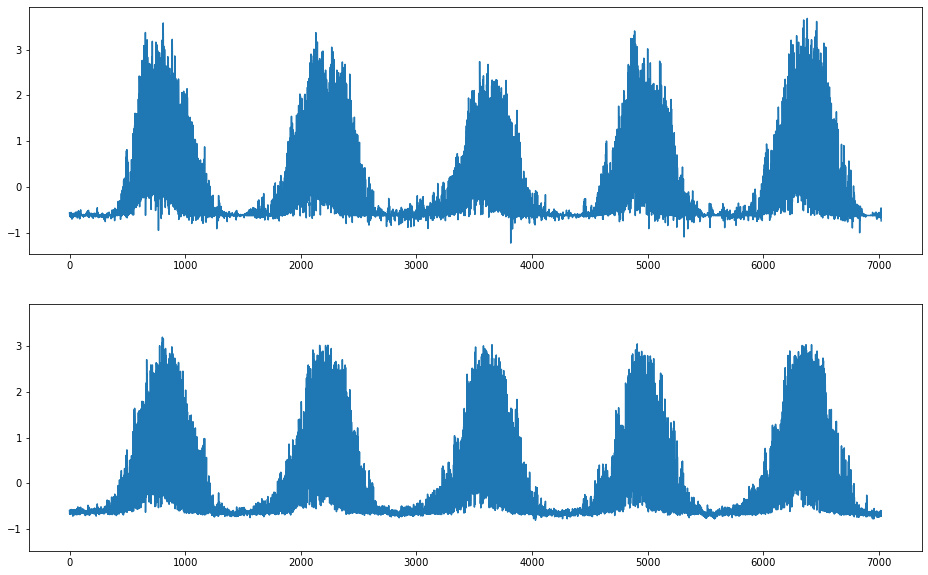

In [1581]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16,10), sharey=True)

ax[0].plot(y_test)
ax[1].plot(y_pred)

In [1582]:
residuals = y_test - y_pred.flatten()
res_r = list(range(len(residuals)))

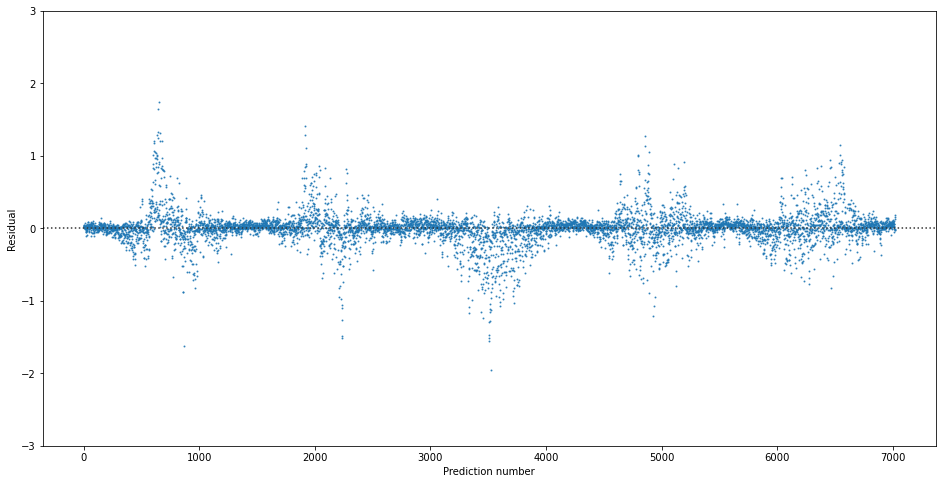

In [1583]:
fig = plt.figure(figsize=(16,8))
sns.residplot(x=res_r, y=residuals, scatter_kws=dict(s=1))
plt.xlabel('Prediction number')
plt.ylabel('Residual')
plt.ylim(-3,3)
plt.show()

Generate new values but also adding the month and time of day to the data

In [1584]:
def generate_vals_with_month(means, st_dev, co2_mean, co2_std, warming, size):
    air_temp = np.random.normal(means['Air Temp'] + warming, st_dev['Air Temp'], size)
    par = np.random.normal(means['PAR'], st_dev['PAR'], size)
    nox_conc = np.random.normal(means['NOx Conc. 33m'], st_dev['NOx Conc. 33m'], size)
    rel_hum = np.random.normal(means['Rel. Humidity'], st_dev['Rel. Humidity'], size)
    co2_conc = np.random.normal(co2_mean, co2_std, size)
    month = np.random.uniform(7, 7, size)
    hour = np.random.uniform(11, 15, size)
    
    return np.array([air_temp, par, nox_conc, co2_conc, rel_hum, month, hour]).T

In [1585]:
vals = generate_vals_with_month(means, st_dev, 450, 15, 0.5, 200)

In [1586]:
pscaler = StandardScaler()
predscaler = pscaler.fit(df2.drop('GPP', axis=1))
vals = pscaler.transform(vals)

G:\ProgramData\Python\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [1588]:
predictions = model11.predict(vals)

In [1589]:
tscaler = StandardScaler()
targetscaler = tscaler.fit(df['GPP'].values.reshape(-1, 1))
inv = targetscaler.inverse_transform(predictions)

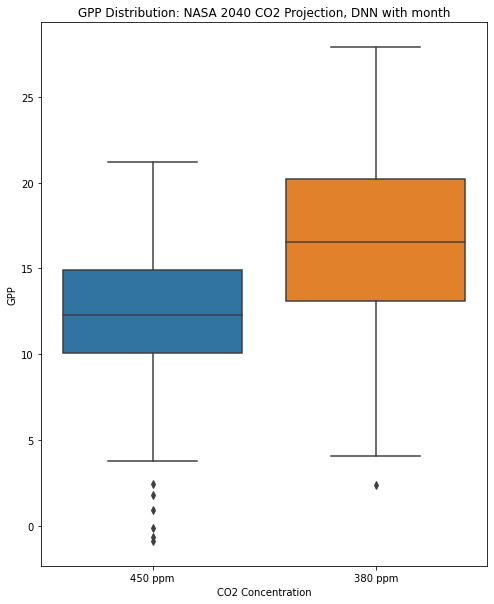

In [1591]:
fig = plt.figure(figsize=(8,10))
box = sns.boxplot(data=[inv, gpp], orient='l')
box.set_xticklabels(['450 ppm', '380 ppm'])
plt.title('GPP Distribution: NASA 2040 CO2 Projection, DNN with month')
plt.xlabel('CO2 Concentration')
plt.ylabel('GPP')
plt.show()

In [1592]:
t_stat, p_value = ttest_ind(inv, gpp)
alpha = 0.05

if p_value < alpha:
     print("Reject the null hypothesis; there is a significant difference between the sample mean and the hypothesized population mean at the 95% confidence level.")
else:
    print("Fail to reject the null hypothesis; there is no significant difference between the sample mean and the hypothesized population mean at the 95% confidence level.")

Reject the null hypothesis; there is a significant difference between the sample mean and the hypothesized population mean at the 95% confidence level.


In [1593]:
print(p_value)

[3.77492055e-20]


# XGBoost Predictions

In [1594]:
pscaler = StandardScaler()
tscaler = StandardScaler()
predscaler = pscaler.fit(df_6h.iloc[:, 0:5])
targetscaler = tscaler.fit(df_6h.iloc[:, 5].values.reshape(-1, 1))

In [1595]:
vals = generate_vals(means=means, st_dev=st_dev, co2_mean=450, co2_std=15, warming=0.5, size=200)

In [1596]:
vals = predscaler.transform(vals)

G:\ProgramData\Python\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [1597]:
predictions = xgb_model.predict(vals)

In [1598]:
tscaler = StandardScaler()
targetscaler = tscaler.fit(df_6h.iloc[:, 5].values.reshape(-1, 1))
inv = targetscaler.inverse_transform(predictions.reshape(1, -1))

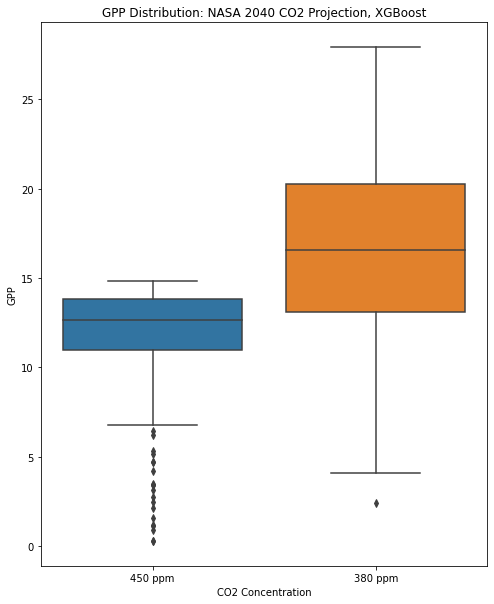

In [1599]:
fig = plt.figure(figsize=(8,10))
box = sns.boxplot(data=[inv, gpp], orient='l')
box.set_xticklabels(['450 ppm', '380 ppm'])
plt.title('GPP Distribution: NASA 2040 CO2 Projection, XGBoost')
plt.xlabel('CO2 Concentration')
plt.ylabel('GPP')
plt.show()

In [1603]:
t_stat, p_value = ttest_ind(inv.flatten(), gpp)
alpha = 0.05

if p_value < alpha:
     print("Reject the null hypothesis; there is a significant difference between the sample mean and the hypothesized population mean at the 95% confidence level.")
else:
    print("Fail to reject the null hypothesis; there is no significant difference between the sample mean and the hypothesized population mean at the 95% confidence level.")

Reject the null hypothesis; there is a significant difference between the sample mean and the hypothesized population mean at the 95% confidence level.


In [1604]:
print(p_value)

9.841112543703743e-27


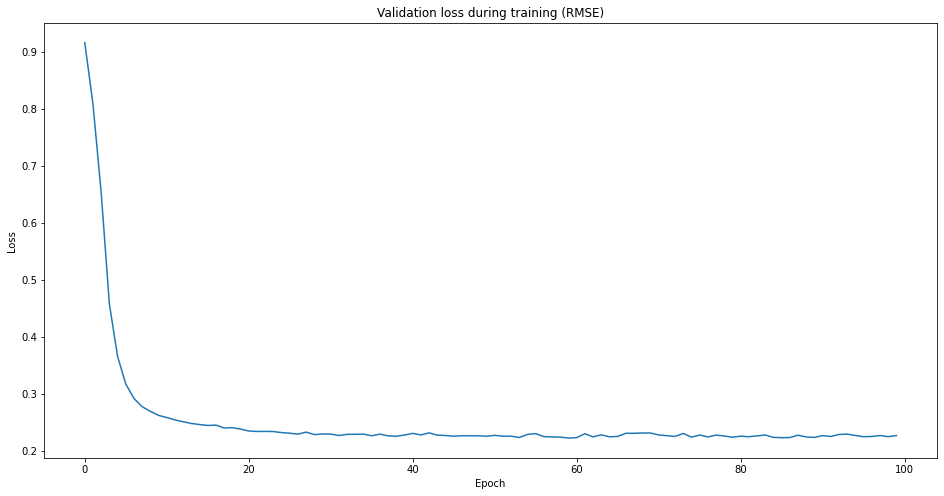

In [1607]:
plt.figure(figsize=(16,8))
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Validation loss during training (RMSE)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

## Visualizing the datasets

Here we are just visualising the datasets across 1 year to see how the averaging windows affects the time series

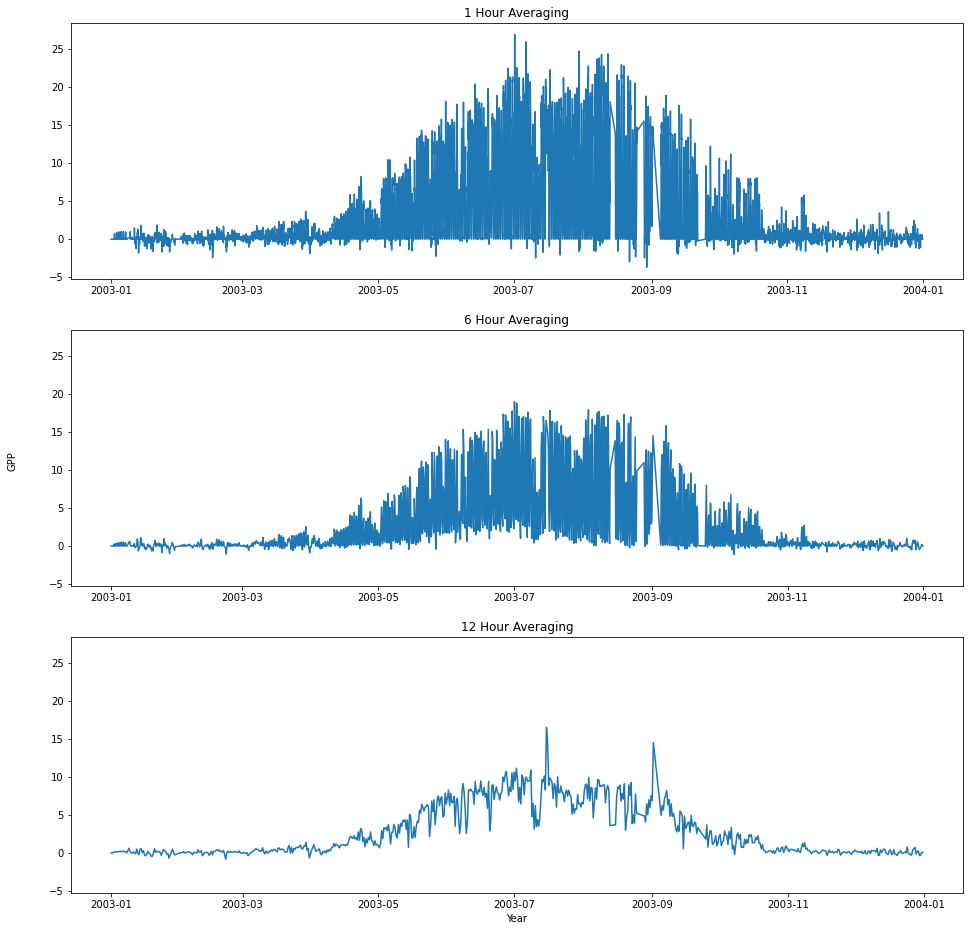

In [1636]:
fig, ax = plt.subplots(3,1, figsize=(16,16), sharey=True)

fig.text(0.07, 0.5, 'GPP', va='center', rotation='vertical')
ax[2].set_xlabel('Year')

ax[0].plot(df[df.index.year < 2004]['GPP'])
ax[0].set_title('1 Hour Averaging')

ax[1].plot(df_6h[df_6h.index.year < 2004]['GPP'])
ax[1].set_title('6 Hour Averaging')

ax[2].plot(df_12h[df_12h.index.year < 2004]['GPP'])
ax[2].set_title('12 Hour Averaging')

plt.show()